In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
%%capture
!pip install wandb

#### wandb Login

In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: dbhadore (use `wandb login --relogin` to force relogin)


True

In [4]:
# Prepare the training dataset
BATCH_SIZE = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# build input pipeline using tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)

In [5]:
def Model():
    inputs = keras.Input(shape=(784,), name="digits")
    x1 = keras.layers.Dense(64, activation="relu")(inputs)
    x2 = keras.layers.Dense(64, activation="relu")(x1)
    outputs = keras.layers.Dense(10, name="predictions")(x2)

    return keras.Model(inputs=inputs, outputs=outputs)

def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

In [6]:
def train(train_dataset,
          val_dataset, 
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=10, 
          log_step=200, 
          val_log_step=50):
    
  
    table = wandb.Table(columns=["epochs", "loss", "acc", 'val_loss', 'val_accuracy'])
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train, 
                                    model, optimizer, 
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val, 
                                       model, loss_fn, 
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc), 
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})
        table.add_data(epoch, np.mean(train_loss), float(train_acc), np.mean(val_loss), np.mean(val_loss))
        
    mectrics_artifact = wandb.Artifact('Dhiman_Matrics_Arifact',type='Metrics')
    mectrics_artifact.add(table,'Dhiman_Metrics_Table')
    wandb.log_artifact(mectrics_artifact)
        

In [7]:
def sweep_train():
    # Specify the hyperparameter to be tuned along with
    # an initial value
    config_defaults = {
        'batch_size': 8,
        'learning_rate': 0.01
    }

    # Initialize wandb with a sample project name
    wandb.init(config=config_defaults)

    # Specify the other hyperparameters to the configuration, if any
    wandb.config.epochs = 7
    wandb.config.log_step = 200
    wandb.config.val_log_step = 50
    wandb.config.architecture_name = "CNN"
    wandb.config.dataset_name = "CIFAR-10"

    # build input pipeline using tf.data
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(wandb.config.batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = val_dataset.batch(wandb.config.batch_size)

    # initialize model
    model = Model()

    # Instantiate an optimizer to train the model.
    optimizer = keras.optimizers.SGD(learning_rate=wandb.config.learning_rate)
    # Instantiate a loss function.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Prepare the metrics.
    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    
    (x_train1, y_train1), (x_test1, y_test1) = keras.datasets.mnist.load_data()

    from matplotlib import pyplot
    for i in range(9):
        # define subplot
        pyplot.subplot(330 + 1 + i)
        # plot raw pixel data
        pyplot.imshow(x_train1[i], cmap=pyplot.get_cmap('gray'))
        # show the figure
    wandb.log({"Training Data Sample": pyplot})
    pyplot.show()

    train(train_dataset,
          val_dataset, 
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=wandb.config.epochs, 
          log_step=wandb.config.log_step, 
          val_log_step=wandb.config.val_log_step)

In [8]:
sweep_config = {
  'method': 'bayes', 
  'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'max_iter': 27,
      's':2
  },
  'parameters': {
      'batch_size': {
          'values': [8, 16, 32, 64, 128]
      },
      'learning_rate':{
          'values': [0.01, 0.005, 0.001, 0.0005]
      }
  }
}

Create sweep with ID: bguxzrjq
Sweep URL: https://wandb.ai/dbhadore/tf-dhiman/sweeps/bguxzrjq


wandb: Agent Starting Run: h37qw5vt with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.01


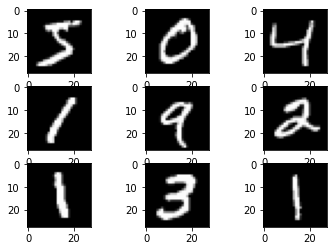


Start of epoch 0
Training acc over epoch: 0.1118
Validation acc: 0.1135

Start of epoch 1
Training acc over epoch: 0.1121
Validation acc: 0.1028

Start of epoch 2
Training acc over epoch: 0.1119
Validation acc: 0.1028

Start of epoch 3
Training acc over epoch: 0.1120
Validation acc: 0.1028

Start of epoch 4
Training acc over epoch: 0.1120
Validation acc: 0.1028

Start of epoch 5
Training acc over epoch: 0.1115
Validation acc: 0.1135

Start of epoch 6
Training acc over epoch: 0.1122
Validation acc: 0.1135


_runtime,245
_timestamp,1622336127
_step,7
epochs,6
loss,2.30155
acc,0.11223
val_loss,2.30129
val_acc,0.1135


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▁▁▁▁▁▁
acc,▄▇▅▆▆▁█
val_loss,▄▇▆█▅▁▂
val_acc,█▁▁▁▁██


wandb: Agent Starting Run: hvbhdx5q with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.005


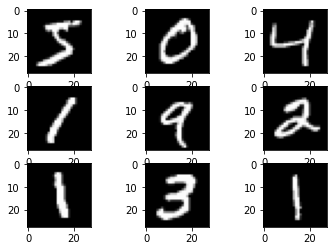


Start of epoch 0
Training acc over epoch: 0.1164
Validation acc: 0.1140

Start of epoch 1
Training acc over epoch: 0.1547
Validation acc: 0.1986

Start of epoch 2
Training acc over epoch: 0.2087
Validation acc: 0.2174

Start of epoch 3
Training acc over epoch: 0.2544
Validation acc: 0.2827

Start of epoch 4
Training acc over epoch: 0.2682
Validation acc: 0.2915

Start of epoch 5
Training acc over epoch: 0.1062
Validation acc: 0.1028

Start of epoch 6
Training acc over epoch: 0.1094
Validation acc: 0.1135


_runtime,177
_timestamp,1622336312
_step,7
epochs,6
loss,2.30848
acc,0.10945
val_loss,2.3017
val_acc,0.1135


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▃▂▁▁▄▄
acc,▁▃▅▇█▁▁
val_loss,█▅▃▁▁██
val_acc,▁▅▅██▁▁


wandb: Agent Starting Run: 2ymfszn6 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.01


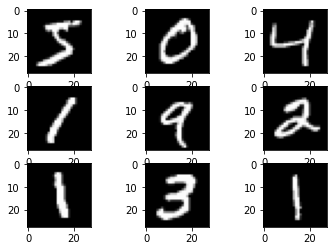


Start of epoch 0
Training acc over epoch: 0.1116
Validation acc: 0.1135

Start of epoch 1
Training acc over epoch: 0.1118
Validation acc: 0.1135

Start of epoch 2
Training acc over epoch: 0.1117
Validation acc: 0.1135

Start of epoch 3
Training acc over epoch: 0.1117
Validation acc: 0.1135

Start of epoch 4
Training acc over epoch: 0.1116
Validation acc: 0.1135

Start of epoch 5
Training acc over epoch: 0.1121
Validation acc: 0.1028

Start of epoch 6
Training acc over epoch: 0.1117
Validation acc: 0.1028


_runtime,284
_timestamp,1622336603
_step,7
epochs,6
loss,2.30143
acc,0.11168
val_loss,2.30134
val_acc,0.1028


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▁▁▁▁▁▁
acc,▁▃▂▃▁█▂
val_loss,▃▂▅▁▂█▄
val_acc,█████▁▁


wandb: Agent Starting Run: odiva3q6 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.005


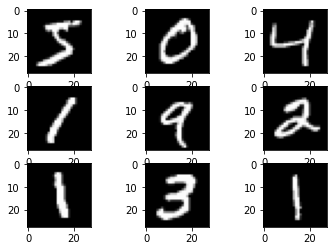


Start of epoch 0
Training acc over epoch: 0.1118
Validation acc: 0.1135

Start of epoch 1
Training acc over epoch: 0.1124
Validation acc: 0.1135

Start of epoch 2
Training acc over epoch: 0.1124
Validation acc: 0.1135

Start of epoch 3
Training acc over epoch: 0.1124
Validation acc: 0.1135

Start of epoch 4
Training acc over epoch: 0.1124
Validation acc: 0.1135

Start of epoch 5
Training acc over epoch: 0.1124
Validation acc: 0.1135

Start of epoch 6
Training acc over epoch: 0.1124
Validation acc: 0.1135


_runtime,283
_timestamp,1622336894
_step,7
epochs,6
loss,2.30139
acc,0.11237
val_loss,2.30114
val_acc,0.1135


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▁▁▁▁▁▁
acc,▁██████
val_loss,█▁▇▃▃█▂
val_acc,▁▁▁▁▁▁▁


wandb: Agent Starting Run: s7j6ftyx with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001


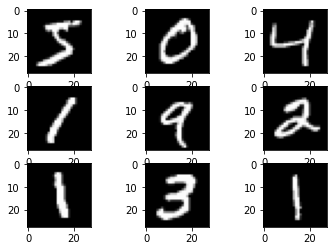


Start of epoch 0
Training acc over epoch: 0.7486
Validation acc: 0.8313

Start of epoch 1
Training acc over epoch: 0.8544
Validation acc: 0.8854

Start of epoch 2
Training acc over epoch: 0.8974
Validation acc: 0.9091

Start of epoch 3
Training acc over epoch: 0.9117
Validation acc: 0.9116

Start of epoch 4
Training acc over epoch: 0.9207
Validation acc: 0.9230

Start of epoch 5
Training acc over epoch: 0.9278
Validation acc: 0.9230

Start of epoch 6
Training acc over epoch: 0.9327
Validation acc: 0.9313


_runtime,170
_timestamp,1622337072
_step,7
epochs,6
loss,0.23798
acc,0.93265
val_loss,0.27067
val_acc,0.9313


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
acc,▁▅▇▇███
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇▇█


wandb: Agent Starting Run: 0rmo9v8v with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001


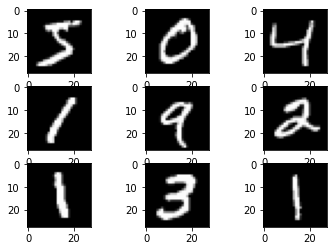


Start of epoch 0
Training acc over epoch: 0.8311
Validation acc: 0.8886

Start of epoch 1
Training acc over epoch: 0.9060
Validation acc: 0.9151

Start of epoch 2
Training acc over epoch: 0.9229
Validation acc: 0.9208

Start of epoch 3
Training acc over epoch: 0.9324
Validation acc: 0.9303

Start of epoch 4
Training acc over epoch: 0.9378
Validation acc: 0.9301

Start of epoch 5
Training acc over epoch: 0.9424
Validation acc: 0.9352

Start of epoch 6
Training acc over epoch: 0.9464
Validation acc: 0.9360


_runtime,637
_timestamp,1622337717
_step,7
epochs,6
loss,0.18029
acc,0.9464
val_loss,0.24237
val_acc,0.936


_runtime,▁▁▁▇████
_timestamp,▁▁▁▇████
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▆▇▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: aln6wne5 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


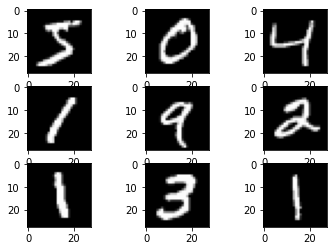


Start of epoch 0
Training acc over epoch: 0.8093
Validation acc: 0.8694

Start of epoch 1
Training acc over epoch: 0.8835
Validation acc: 0.8906

Start of epoch 2
Training acc over epoch: 0.9064
Validation acc: 0.8986

Start of epoch 3
Training acc over epoch: 0.9190
Validation acc: 0.9058

Start of epoch 4
Training acc over epoch: 0.9272
Validation acc: 0.9120

Start of epoch 5
Training acc over epoch: 0.9325
Validation acc: 0.9158

Start of epoch 6
Training acc over epoch: 0.9374
Validation acc: 0.9181


_runtime,85
_timestamp,1622337809
_step,7
epochs,6
loss,0.2264
acc,0.93738
val_loss,0.32852
val_acc,0.9181


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▅▆▇██


wandb: Agent Starting Run: zzg3vflx with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


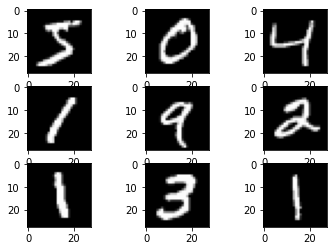


Start of epoch 0
Training acc over epoch: 0.7504
Validation acc: 0.8337

Start of epoch 1
Training acc over epoch: 0.8550
Validation acc: 0.8734

Start of epoch 2
Training acc over epoch: 0.8813
Validation acc: 0.8896

Start of epoch 3
Training acc over epoch: 0.8977
Validation acc: 0.8959

Start of epoch 4
Training acc over epoch: 0.9063
Validation acc: 0.9051

Start of epoch 5
Training acc over epoch: 0.9128
Validation acc: 0.9092

Start of epoch 6
Training acc over epoch: 0.9183
Validation acc: 0.9117


_runtime,87
_timestamp,1622337904
_step,7
epochs,6
loss,0.29562
acc,0.91825
val_loss,0.36576
val_acc,0.9117


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇███
val_loss,█▅▃▃▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: 2bxmf55l with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


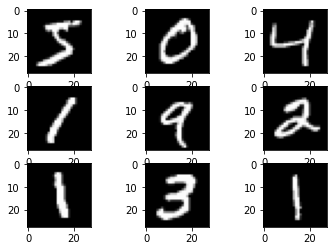


Start of epoch 0
Training acc over epoch: 0.7715
Validation acc: 0.8404

Start of epoch 1
Training acc over epoch: 0.8554
Validation acc: 0.8741

Start of epoch 2
Training acc over epoch: 0.8844
Validation acc: 0.8938

Start of epoch 3
Training acc over epoch: 0.8989
Validation acc: 0.9004

Start of epoch 4
Training acc over epoch: 0.9081
Validation acc: 0.9029

Start of epoch 5
Training acc over epoch: 0.9168
Validation acc: 0.9098

Start of epoch 6
Training acc over epoch: 0.9215
Validation acc: 0.9132


_runtime,90
_timestamp,1622338002
_step,7
epochs,6
loss,0.27533
acc,0.92152
val_loss,0.32794
val_acc,0.9132


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: 3qortfjk with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


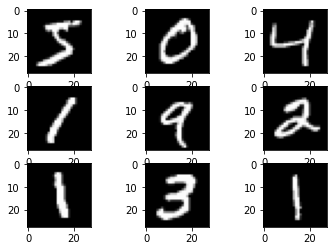


Start of epoch 0
Training acc over epoch: 0.8099
Validation acc: 0.8759

Start of epoch 1
Training acc over epoch: 0.8837
Validation acc: 0.8993

Start of epoch 2
Training acc over epoch: 0.9067
Validation acc: 0.9104

Start of epoch 3
Training acc over epoch: 0.9181
Validation acc: 0.9150

Start of epoch 4
Training acc over epoch: 0.9277
Validation acc: 0.9243

Start of epoch 5
Training acc over epoch: 0.9321
Validation acc: 0.9250

Start of epoch 6
Training acc over epoch: 0.9369
Validation acc: 0.9277


_runtime,77
_timestamp,1622338087
_step,7
epochs,6
loss,0.21786
acc,0.93692
val_loss,0.25972
val_acc,0.9277


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▆███


wandb: Agent Starting Run: kxlwf6ms with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


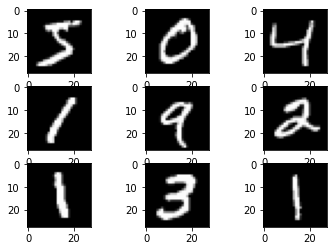


Start of epoch 0
Training acc over epoch: 0.7810
Validation acc: 0.8415

Start of epoch 1
Training acc over epoch: 0.8738
Validation acc: 0.8809

Start of epoch 2
Training acc over epoch: 0.8989
Validation acc: 0.9031

Start of epoch 3
Training acc over epoch: 0.9116
Validation acc: 0.9103

Start of epoch 4
Training acc over epoch: 0.9209
Validation acc: 0.9153

Start of epoch 5
Training acc over epoch: 0.9265
Validation acc: 0.9226

Start of epoch 6
Training acc over epoch: 0.9316
Validation acc: 0.9254


_runtime,77
_timestamp,1622338172
_step,7
epochs,6
loss,0.23746
acc,0.9316
val_loss,0.2742
val_acc,0.9254


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇███
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: 7mbyctuz with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


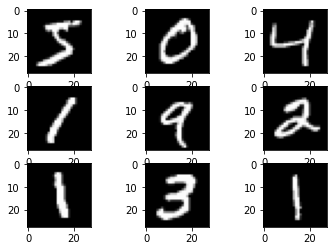


Start of epoch 0
Training acc over epoch: 0.7918
Validation acc: 0.8646

Start of epoch 1
Training acc over epoch: 0.8781
Validation acc: 0.8936

Start of epoch 2
Training acc over epoch: 0.9017
Validation acc: 0.9038

Start of epoch 3
Training acc over epoch: 0.9138
Validation acc: 0.9110

Start of epoch 4
Training acc over epoch: 0.9217
Validation acc: 0.9179

Start of epoch 5
Training acc over epoch: 0.9277
Validation acc: 0.9189

Start of epoch 6
Training acc over epoch: 0.9334
Validation acc: 0.9267


_runtime,75
_timestamp,1622338256
_step,7
epochs,6
loss,0.22992
acc,0.93338
val_loss,0.25388
val_acc,0.9267


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▃▂▁▁
val_acc,▁▄▅▆▇▇█


wandb: Agent Starting Run: qdd05y54 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


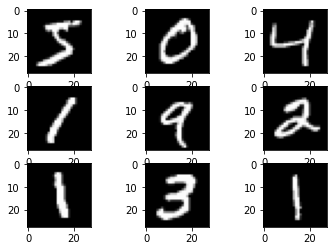


Start of epoch 0
Training acc over epoch: 0.7489
Validation acc: 0.8294

Start of epoch 1
Training acc over epoch: 0.8534
Validation acc: 0.8682

Start of epoch 2
Training acc over epoch: 0.8806
Validation acc: 0.8877

Start of epoch 3
Training acc over epoch: 0.8965
Validation acc: 0.8947

Start of epoch 4
Training acc over epoch: 0.9048
Validation acc: 0.9025

Start of epoch 5


_runtime,59
_timestamp,1622338323
_step,5
epochs,4
loss,0.35799
acc,0.90478
val_loss,0.39863
val_acc,0.9025


_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█
epochs,▁▃▅▆█
loss,█▂▂▁▁
acc,▁▆▇██
val_loss,█▄▂▂▁
val_acc,▁▅▇▇█


wandb: Agent Starting Run: ccdg19n9 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


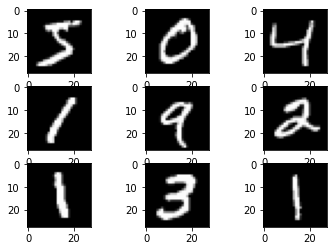


Start of epoch 0
Training acc over epoch: 0.7693
Validation acc: 0.8360

Start of epoch 1
Training acc over epoch: 0.8584
Validation acc: 0.8765

Start of epoch 2
Training acc over epoch: 0.8874
Validation acc: 0.8952

Start of epoch 3
Training acc over epoch: 0.9050
Validation acc: 0.8979

Start of epoch 4


_runtime,48
_timestamp,1622338380
_step,4
epochs,3
loss,0.35812
acc,0.90502
val_loss,0.41093
val_acc,0.8979


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▂▁
val_acc,▁▆██


wandb: Agent Starting Run: rswf7i1o with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


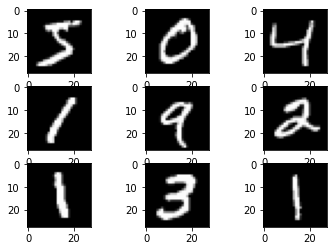


Start of epoch 0
Training acc over epoch: 0.7741
Validation acc: 0.8563

Start of epoch 1
Training acc over epoch: 0.8727
Validation acc: 0.8863

Start of epoch 2
Training acc over epoch: 0.8983
Validation acc: 0.9009

Start of epoch 3
Training acc over epoch: 0.9111
Validation acc: 0.9065

Start of epoch 4
Training acc over epoch: 0.9189
Validation acc: 0.9158

Start of epoch 5
Training acc over epoch: 0.9252
Validation acc: 0.9176

Start of epoch 6
Training acc over epoch: 0.9299
Validation acc: 0.9230


_runtime,77
_timestamp,1622338470
_step,7
epochs,6
loss,0.24193
acc,0.9299
val_loss,0.27862
val_acc,0.923


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▇▇███
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▆▇▇█


wandb: Agent Starting Run: 4d0on7kv with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


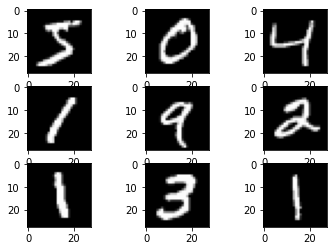


Start of epoch 0
Training acc over epoch: 0.7381
Validation acc: 0.8260

Start of epoch 1
Training acc over epoch: 0.8453
Validation acc: 0.8702

Start of epoch 2
Training acc over epoch: 0.8780
Validation acc: 0.8836

Start of epoch 3
Training acc over epoch: 0.8949
Validation acc: 0.8911

Start of epoch 4
Training acc over epoch: 0.9066
Validation acc: 0.8977

Start of epoch 5
Training acc over epoch: 0.9140
Validation acc: 0.9065

Start of epoch 6
Training acc over epoch: 0.9198
Validation acc: 0.9123


_runtime,77
_timestamp,1622338555
_step,7
epochs,6
loss,0.2824
acc,0.91977
val_loss,0.35262
val_acc,0.9123


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▆▇██


wandb: Agent Starting Run: 5r7nvjkc with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


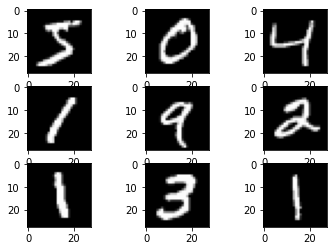


Start of epoch 0
Training acc over epoch: 0.7451
Validation acc: 0.8280

Start of epoch 1
Training acc over epoch: 0.8519
Validation acc: 0.8736

Start of epoch 2
Training acc over epoch: 0.8814
Validation acc: 0.8839

Start of epoch 3
Training acc over epoch: 0.8969
Validation acc: 0.8947

Start of epoch 4
Training acc over epoch: 0.9071
Validation acc: 0.9039

Start of epoch 5
Training acc over epoch: 0.9139
Validation acc: 0.9079

Start of epoch 6


_runtime,67
_timestamp,1622338630
_step,6
epochs,5
loss,0.30549
acc,0.91393
val_loss,0.36209
val_acc,0.9079


_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█
epochs,▁▂▄▅▇█
loss,█▂▂▁▁▁
acc,▁▅▇▇██
val_loss,█▄▃▂▂▁
val_acc,▁▅▆▇██


wandb: Agent Starting Run: rsgpvv1g with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


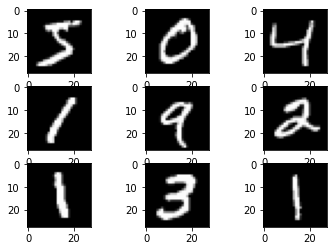


Start of epoch 0
Training acc over epoch: 0.8213
Validation acc: 0.8706

Start of epoch 1
Training acc over epoch: 0.8876
Validation acc: 0.8983

Start of epoch 2
Training acc over epoch: 0.9081
Validation acc: 0.9091

Start of epoch 3
Training acc over epoch: 0.9203
Validation acc: 0.9201

Start of epoch 4
Training acc over epoch: 0.9286
Validation acc: 0.9198

Start of epoch 5
Training acc over epoch: 0.9343
Validation acc: 0.9235

Start of epoch 6
Training acc over epoch: 0.9403
Validation acc: 0.9267


_runtime,77
_timestamp,1622338713
_step,7
epochs,6
loss,0.21126
acc,0.94028
val_loss,0.28271
val_acc,0.9267


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: qi3vrr3t with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


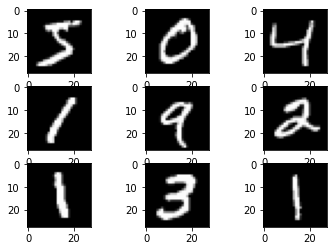


Start of epoch 0
Training acc over epoch: 0.7798
Validation acc: 0.8428

Start of epoch 1
Training acc over epoch: 0.8662
Validation acc: 0.8781

Start of epoch 2
Training acc over epoch: 0.8928
Validation acc: 0.8984

Start of epoch 3
Training acc over epoch: 0.9065
Validation acc: 0.9054

Start of epoch 4
Training acc over epoch: 0.9165
Validation acc: 0.9137

Start of epoch 5
Training acc over epoch: 0.9224
Validation acc: 0.9203

Start of epoch 6
Training acc over epoch: 0.9284
Validation acc: 0.9224


_runtime,77
_timestamp,1622338798
_step,7
epochs,6
loss,0.24228
acc,0.92838
val_loss,0.27286
val_acc,0.9224


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: 6r2qdo02 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


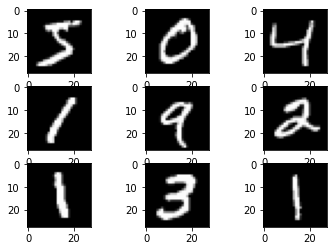


Start of epoch 0
Training acc over epoch: 0.7352
Validation acc: 0.8259

Start of epoch 1
Training acc over epoch: 0.8477
Validation acc: 0.8579

Start of epoch 2
Training acc over epoch: 0.8826
Validation acc: 0.8831

Start of epoch 3
Training acc over epoch: 0.8986
Validation acc: 0.8966

Start of epoch 4
Training acc over epoch: 0.9086
Validation acc: 0.8992

Start of epoch 5
Training acc over epoch: 0.9157
Validation acc: 0.9057

Start of epoch 6
Training acc over epoch: 0.9213
Validation acc: 0.9122


_runtime,77
_timestamp,1622338884
_step,7
epochs,6
loss,0.2795
acc,0.92127
val_loss,0.34319
val_acc,0.9122


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
acc,▁▅▇▇███
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇▇▇█


wandb: Agent Starting Run: 9zar3vac with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


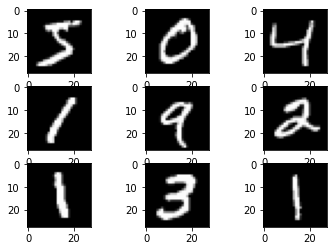


Start of epoch 0
Training acc over epoch: 0.7287
Validation acc: 0.8265

Start of epoch 1
Training acc over epoch: 0.8392
Validation acc: 0.8595

Start of epoch 2
Training acc over epoch: 0.8701
Validation acc: 0.8704

Start of epoch 3
Training acc over epoch: 0.8866
Validation acc: 0.8847

Start of epoch 4
Training acc over epoch: 0.8967
Validation acc: 0.8993

Start of epoch 5
Training acc over epoch: 0.9054
Validation acc: 0.9034

Start of epoch 6
Training acc over epoch: 0.9110
Validation acc: 0.9084


_runtime,277
_timestamp,1622339168
_step,7
epochs,6
loss,0.31577
acc,0.91102
val_loss,0.34196
val_acc,0.9084


_runtime,▁▁▇▇▇███
_timestamp,▁▁▇▇▇███
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▂▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▄▃▂▁▁
val_acc,▁▄▅▆▇██


wandb: Agent Starting Run: fekb8hzb with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


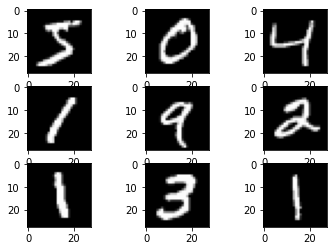


Start of epoch 0
Training acc over epoch: 0.8132
Validation acc: 0.8657

Start of epoch 1
Training acc over epoch: 0.8859
Validation acc: 0.8949

Start of epoch 2
Training acc over epoch: 0.9075
Validation acc: 0.9087

Start of epoch 3
Training acc over epoch: 0.9193
Validation acc: 0.9112

Start of epoch 4
Training acc over epoch: 0.9271
Validation acc: 0.9140

Start of epoch 5
Training acc over epoch: 0.9337
Validation acc: 0.9185

Start of epoch 6
Training acc over epoch: 0.9387
Validation acc: 0.9227


_runtime,72
_timestamp,1622339248
_step,7
epochs,6
loss,0.21593
acc,0.93873
val_loss,0.30495
val_acc,0.9227


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇▇█


wandb: Agent Starting Run: 9c2rn970 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


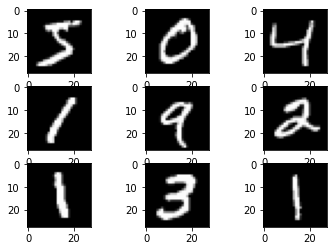


Start of epoch 0
Training acc over epoch: 0.7778
Validation acc: 0.8537

Start of epoch 1
Training acc over epoch: 0.8709
Validation acc: 0.8858

Start of epoch 2
Training acc over epoch: 0.8942
Validation acc: 0.9003

Start of epoch 3
Training acc over epoch: 0.9071
Validation acc: 0.9086

Start of epoch 4
Training acc over epoch: 0.9167
Validation acc: 0.9110

Start of epoch 5
Training acc over epoch: 0.9226
Validation acc: 0.9138

Start of epoch 6
Training acc over epoch: 0.9280
Validation acc: 0.9187


_runtime,74
_timestamp,1622339330
_step,7
epochs,6
loss,0.25063
acc,0.92798
val_loss,0.30664
val_acc,0.9187


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇▇▇█


wandb: Agent Starting Run: 97jz3nhq with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


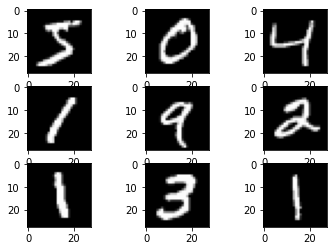


Start of epoch 0
Training acc over epoch: 0.7867
Validation acc: 0.8520

Start of epoch 1
Training acc over epoch: 0.8662
Validation acc: 0.8784

Start of epoch 2
Training acc over epoch: 0.8913
Validation acc: 0.8909

Start of epoch 3
Training acc over epoch: 0.9052
Validation acc: 0.8996

Start of epoch 4
Training acc over epoch: 0.9140
Validation acc: 0.9096

Start of epoch 5
Training acc over epoch: 0.9207
Validation acc: 0.9158

Start of epoch 6
Training acc over epoch: 0.9259
Validation acc: 0.9165


_runtime,77
_timestamp,1622339414
_step,7
epochs,6
loss,0.26548
acc,0.9259
val_loss,0.31746
val_acc,0.9165


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▃▂▁▁
val_acc,▁▄▅▆▇██


wandb: Agent Starting Run: frs0m4pl with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


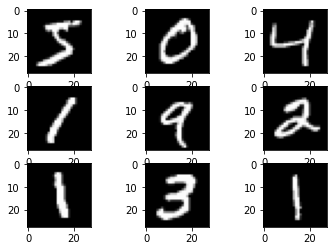


Start of epoch 0
Training acc over epoch: 0.7888
Validation acc: 0.8518

Start of epoch 1
Training acc over epoch: 0.8724
Validation acc: 0.8875

Start of epoch 2
Training acc over epoch: 0.8962
Validation acc: 0.8981

Start of epoch 3
Training acc over epoch: 0.9099
Validation acc: 0.9058

Start of epoch 4
Training acc over epoch: 0.9173
Validation acc: 0.9109

Start of epoch 5
Training acc over epoch: 0.9232
Validation acc: 0.9174

Start of epoch 6
Training acc over epoch: 0.9283
Validation acc: 0.9219


_runtime,77
_timestamp,1622339498
_step,7
epochs,6
loss,0.24567
acc,0.92825
val_loss,0.27911
val_acc,0.9219


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▆▇██


wandb: Agent Starting Run: iw11r82a with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


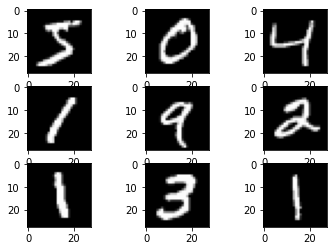


Start of epoch 0
Training acc over epoch: 0.7904
Validation acc: 0.8492

Start of epoch 1
Training acc over epoch: 0.8692
Validation acc: 0.8760

Start of epoch 2
Training acc over epoch: 0.8936
Validation acc: 0.8940

Start of epoch 3
Training acc over epoch: 0.9072
Validation acc: 0.9044

Start of epoch 4
Training acc over epoch: 0.9158
Validation acc: 0.9086

Start of epoch 5
Training acc over epoch: 0.9231
Validation acc: 0.9145

Start of epoch 6
Training acc over epoch: 0.9277
Validation acc: 0.9156


_runtime,77
_timestamp,1622339584
_step,7
epochs,6
loss,0.2546
acc,0.92767
val_loss,0.34309
val_acc,0.9156


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: ngjd8ppl with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


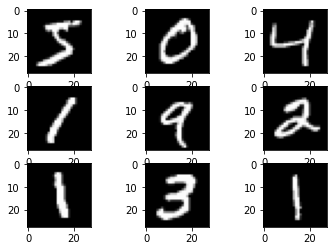


Start of epoch 0
Training acc over epoch: 0.7904
Validation acc: 0.8451

Start of epoch 1
Training acc over epoch: 0.8708
Validation acc: 0.8790

Start of epoch 2
Training acc over epoch: 0.8966
Validation acc: 0.8940

Start of epoch 3
Training acc over epoch: 0.9102
Validation acc: 0.9039

Start of epoch 4
Training acc over epoch: 0.9198
Validation acc: 0.9117

Start of epoch 5


_runtime,57
_timestamp,1622339649
_step,5
epochs,4
loss,0.29405
acc,0.91982
val_loss,0.37108
val_acc,0.9117


_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█
epochs,▁▃▅▆█
loss,█▂▁▁▁
acc,▁▅▇▇█
val_loss,█▄▂▂▁
val_acc,▁▅▆▇█


wandb: Agent Starting Run: yek02kg8 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


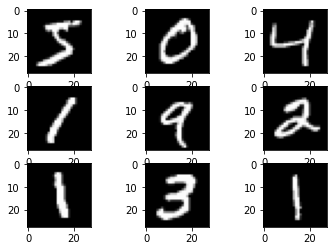


Start of epoch 0
Training acc over epoch: 0.7746
Validation acc: 0.8458

Start of epoch 1
Training acc over epoch: 0.8683
Validation acc: 0.8815

Start of epoch 2
Training acc over epoch: 0.8927
Validation acc: 0.8933

Start of epoch 3
Training acc over epoch: 0.9062
Validation acc: 0.8989

Start of epoch 4


_runtime,47
_timestamp,1622339704
_step,4
epochs,3
loss,0.34172
acc,0.90625
val_loss,0.38056
val_acc,0.8989


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▂▁
val_acc,▁▆▇█


wandb: Agent Starting Run: 6i0v434s with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


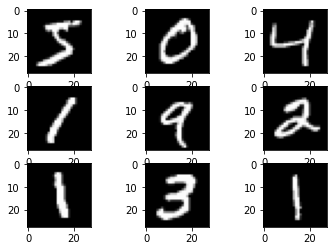


Start of epoch 0
Training acc over epoch: 0.7830
Validation acc: 0.8551

Start of epoch 1
Training acc over epoch: 0.8685
Validation acc: 0.8772

Start of epoch 2
Training acc over epoch: 0.8934
Validation acc: 0.8969

Start of epoch 3
Training acc over epoch: 0.9067
Validation acc: 0.9060

Start of epoch 4


_runtime,48
_timestamp,1622339766
_step,4
epochs,3
loss,0.34178
acc,0.90673
val_loss,0.38106
val_acc,0.906


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▂▁
val_acc,▁▄▇█


wandb: Agent Starting Run: u84lmafa with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


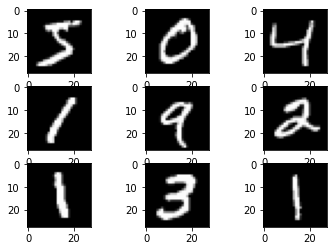


Start of epoch 0
Training acc over epoch: 0.7690
Validation acc: 0.8300

Start of epoch 1
Training acc over epoch: 0.8524
Validation acc: 0.8652

Start of epoch 2
Training acc over epoch: 0.8805
Validation acc: 0.8812

Start of epoch 3
Training acc over epoch: 0.8964
Validation acc: 0.8899

Start of epoch 4


_runtime,47
_timestamp,1622339825
_step,4
epochs,3
loss,0.38199
acc,0.8964
val_loss,0.4488
val_acc,0.8899


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▂▁
val_acc,▁▅▇█


wandb: Agent Starting Run: vk6e361t with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


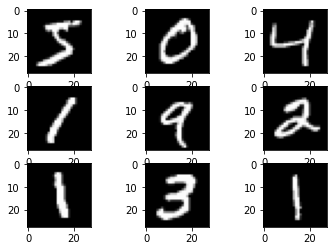


Start of epoch 0
Training acc over epoch: 0.7478
Validation acc: 0.8261

Start of epoch 1
Training acc over epoch: 0.8523
Validation acc: 0.8692

Start of epoch 2
Training acc over epoch: 0.8805
Validation acc: 0.8874

Start of epoch 3
Training acc over epoch: 0.8959
Validation acc: 0.8964

Start of epoch 4


_runtime,47
_timestamp,1622339887
_step,4
epochs,3
loss,0.40304
acc,0.89593
val_loss,0.43984
val_acc,0.8964


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▂▁
val_acc,▁▅▇█


wandb: Agent Starting Run: um1mctpm with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


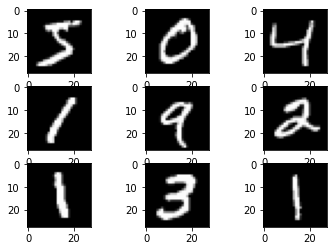


Start of epoch 0
Training acc over epoch: 0.8064
Validation acc: 0.8624

Start of epoch 1
Training acc over epoch: 0.8807
Validation acc: 0.8892

Start of epoch 2
Training acc over epoch: 0.9045
Validation acc: 0.9078

Start of epoch 3
Training acc over epoch: 0.9172
Validation acc: 0.9178

Start of epoch 4
Training acc over epoch: 0.9259
Validation acc: 0.9213

Start of epoch 5
Training acc over epoch: 0.9309
Validation acc: 0.9217

Start of epoch 6
Training acc over epoch: 0.9353
Validation acc: 0.9302


_runtime,77
_timestamp,1622339977
_step,7
epochs,6
loss,0.22545
acc,0.9353
val_loss,0.26667
val_acc,0.9302


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▂▁
val_acc,▁▄▆▇▇▇█


wandb: Agent Starting Run: 9xlhlyow with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


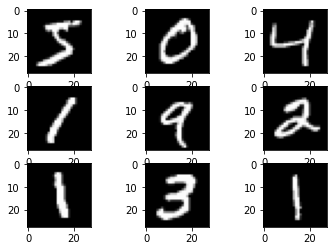


Start of epoch 0
Training acc over epoch: 0.7914
Validation acc: 0.8618

Start of epoch 1
Training acc over epoch: 0.8759
Validation acc: 0.8935

Start of epoch 2
Training acc over epoch: 0.9011
Validation acc: 0.9068

Start of epoch 3
Training acc over epoch: 0.9136
Validation acc: 0.9170

Start of epoch 4
Training acc over epoch: 0.9216
Validation acc: 0.9183

Start of epoch 5
Training acc over epoch: 0.9284
Validation acc: 0.9237

Start of epoch 6
Training acc over epoch: 0.9328
Validation acc: 0.9299


_runtime,78
_timestamp,1622340063
_step,7
epochs,6
loss,0.23322
acc,0.93282
val_loss,0.27752
val_acc,0.9299


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇▇▇█


wandb: Agent Starting Run: kof1yrsf with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


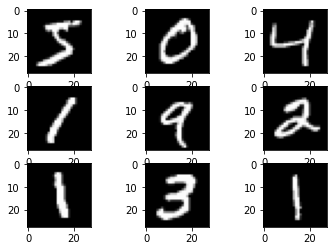


Start of epoch 0
Training acc over epoch: 0.7795
Validation acc: 0.8512

Start of epoch 1
Training acc over epoch: 0.8626
Validation acc: 0.8820

Start of epoch 2
Training acc over epoch: 0.8888
Validation acc: 0.8986

Start of epoch 3
Training acc over epoch: 0.9036
Validation acc: 0.9071

Start of epoch 4
Training acc over epoch: 0.9118
Validation acc: 0.9133

Start of epoch 5
Training acc over epoch: 0.9187
Validation acc: 0.9133

Start of epoch 6
Training acc over epoch: 0.9250
Validation acc: 0.9180


_runtime,78
_timestamp,1622340150
_step,7
epochs,6
loss,0.27
acc,0.92498
val_loss,0.3324
val_acc,0.918


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▂▁
val_acc,▁▄▆▇███


wandb: Agent Starting Run: 808sd01x with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


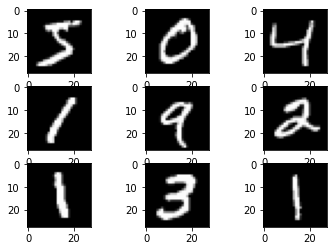


Start of epoch 0
Training acc over epoch: 0.7492
Validation acc: 0.8276

Start of epoch 1
Training acc over epoch: 0.8533
Validation acc: 0.8708

Start of epoch 2
Training acc over epoch: 0.8803
Validation acc: 0.8899

Start of epoch 3
Training acc over epoch: 0.8955
Validation acc: 0.9024

Start of epoch 4
Training acc over epoch: 0.9032
Validation acc: 0.9030

Start of epoch 5
Training acc over epoch: 0.9120
Validation acc: 0.9071

Start of epoch 6
Training acc over epoch: 0.9157
Validation acc: 0.9113


_runtime,77
_timestamp,1622340236
_step,7
epochs,6
loss,0.29515
acc,0.91572
val_loss,0.3404
val_acc,0.9113


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▇▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: rw7pbmzs with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


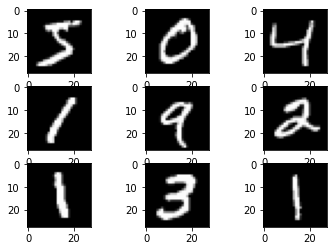


Start of epoch 0
Training acc over epoch: 0.7841
Validation acc: 0.8611

Start of epoch 1
Training acc over epoch: 0.8733
Validation acc: 0.8854

Start of epoch 2
Training acc over epoch: 0.8979
Validation acc: 0.8961

Start of epoch 3
Training acc over epoch: 0.9104
Validation acc: 0.9013

Start of epoch 4
Training acc over epoch: 0.9186
Validation acc: 0.9136

Start of epoch 5
Training acc over epoch: 0.9253
Validation acc: 0.9142

Start of epoch 6
Training acc over epoch: 0.9299
Validation acc: 0.9226


_runtime,77
_timestamp,1622340320
_step,7
epochs,6
loss,0.24192
acc,0.9299
val_loss,0.28573
val_acc,0.9226


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▄▃▂▂▁
val_acc,▁▄▅▆▇▇█


wandb: Agent Starting Run: lilt5spy with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


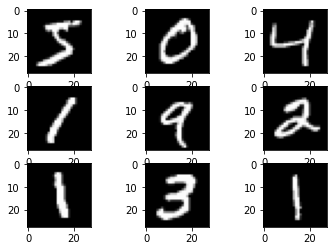


Start of epoch 0
Training acc over epoch: 0.8057
Validation acc: 0.8474

Start of epoch 1
Training acc over epoch: 0.8760
Validation acc: 0.8797

Start of epoch 2
Training acc over epoch: 0.8993
Validation acc: 0.9009

Start of epoch 3
Training acc over epoch: 0.9134
Validation acc: 0.9043

Start of epoch 4
Training acc over epoch: 0.9215
Validation acc: 0.9130

Start of epoch 5
Training acc over epoch: 0.9284
Validation acc: 0.9150

Start of epoch 6
Training acc over epoch: 0.9342
Validation acc: 0.9178


_runtime,3016
_timestamp,1622343344
_step,7
epochs,6
loss,0.23013
acc,0.93418
val_loss,0.29703
val_acc,0.9178


_runtime,▁▁▁▁████
_timestamp,▁▁▁▁████
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇███


wandb: Agent Starting Run: g7dbv8ut with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


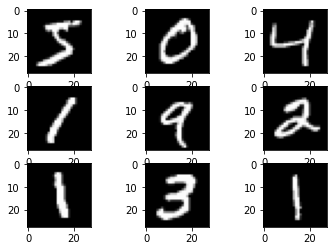


Start of epoch 0
Training acc over epoch: 0.8213
Validation acc: 0.8768

Start of epoch 1
Training acc over epoch: 0.8874
Validation acc: 0.8989

Start of epoch 2
Training acc over epoch: 0.9103
Validation acc: 0.9092

Start of epoch 3
Training acc over epoch: 0.9223
Validation acc: 0.9175

Start of epoch 4
Training acc over epoch: 0.9302
Validation acc: 0.9229

Start of epoch 5
Training acc over epoch: 0.9352
Validation acc: 0.9251

Start of epoch 6
Training acc over epoch: 0.9398
Validation acc: 0.9246


_runtime,81
_timestamp,1622343436
_step,7
epochs,6
loss,0.20481
acc,0.93982
val_loss,0.27952
val_acc,0.9246


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▁▁▁
val_acc,▁▄▆▇███


wandb: Agent Starting Run: k6p46dpu with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


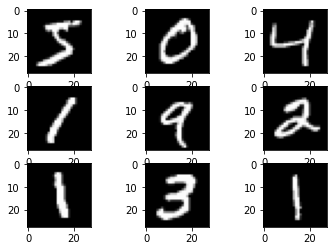


Start of epoch 0
Training acc over epoch: 0.7894
Validation acc: 0.8334

Start of epoch 1
Training acc over epoch: 0.8669
Validation acc: 0.8811

Start of epoch 2
Training acc over epoch: 0.8925
Validation acc: 0.8992

Start of epoch 3
Training acc over epoch: 0.9068
Validation acc: 0.9089

Start of epoch 4
Training acc over epoch: 0.9166
Validation acc: 0.9125

Start of epoch 5
Training acc over epoch: 0.9226
Validation acc: 0.9202

Start of epoch 6
Training acc over epoch: 0.9280
Validation acc: 0.9219


_runtime,87
_timestamp,1622343535
_step,7
epochs,6
loss,0.24622
acc,0.92798
val_loss,0.29389
val_acc,0.9219


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: 2t8oa6bh with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


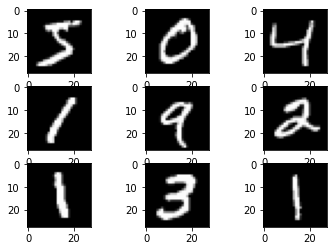


Start of epoch 0
Training acc over epoch: 0.7911
Validation acc: 0.8625

Start of epoch 1
Training acc over epoch: 0.8718
Validation acc: 0.8881

Start of epoch 2
Training acc over epoch: 0.8949
Validation acc: 0.9023

Start of epoch 3
Training acc over epoch: 0.9092
Validation acc: 0.9080

Start of epoch 4
Training acc over epoch: 0.9177
Validation acc: 0.9137

Start of epoch 5


_runtime,60
_timestamp,1622343603
_step,5
epochs,4
loss,0.29206
acc,0.91767
val_loss,0.34273
val_acc,0.9137


_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█
epochs,▁▃▅▆█
loss,█▂▁▁▁
acc,▁▅▇██
val_loss,█▄▃▂▁
val_acc,▁▅▆▇█


wandb: Agent Starting Run: fbuj4wsg with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


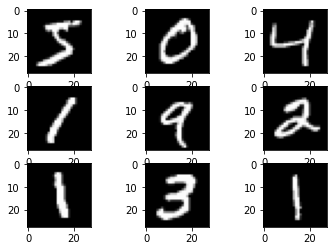


Start of epoch 0
Training acc over epoch: 0.7951
Validation acc: 0.8605

Start of epoch 1
Training acc over epoch: 0.8769
Validation acc: 0.8925

Start of epoch 2
Training acc over epoch: 0.9003
Validation acc: 0.9043

Start of epoch 3
Training acc over epoch: 0.9129
Validation acc: 0.9143

Start of epoch 4


_runtime,51
_timestamp,1622343663
_step,4
epochs,3
loss,0.32117
acc,0.9129
val_loss,0.35239
val_acc,0.9143


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▃▂▁
val_acc,▁▅▇█


wandb: Agent Starting Run: oyars37m with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


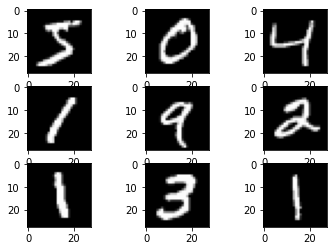


Start of epoch 0
Training acc over epoch: 0.7919
Validation acc: 0.8559

Start of epoch 1
Training acc over epoch: 0.8735
Validation acc: 0.8777

Start of epoch 2
Training acc over epoch: 0.8971
Validation acc: 0.8927

Start of epoch 3
Training acc over epoch: 0.9099
Validation acc: 0.8979

Start of epoch 4


_runtime,48
_timestamp,1622343720
_step,4
epochs,3
loss,0.328
acc,0.9099
val_loss,0.38979
val_acc,0.8979


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▂▁
val_acc,▁▅▇█


wandb: Agent Starting Run: agh8fr9c with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


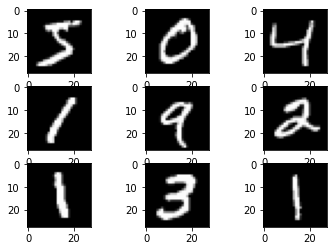


Start of epoch 0
Training acc over epoch: 0.7917
Validation acc: 0.8572

Start of epoch 1
Training acc over epoch: 0.8777
Validation acc: 0.8926

Start of epoch 2
Training acc over epoch: 0.9003
Validation acc: 0.9006

Start of epoch 3
Training acc over epoch: 0.9118
Validation acc: 0.9093

Start of epoch 4
Training acc over epoch: 0.9196
Validation acc: 0.9121

Start of epoch 5
Training acc over epoch: 0.9256
Validation acc: 0.9179

Start of epoch 6
Training acc over epoch: 0.9304
Validation acc: 0.9217


_runtime,75
_timestamp,1622343807
_step,7
epochs,6
loss,0.23743
acc,0.93043
val_loss,0.29134
val_acc,0.9217


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: 99ukcxev with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


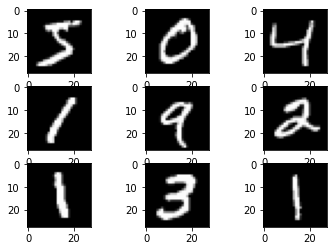


Start of epoch 0
Training acc over epoch: 0.8022
Validation acc: 0.8685

Start of epoch 1
Training acc over epoch: 0.8840
Validation acc: 0.8895

Start of epoch 2
Training acc over epoch: 0.9064
Validation acc: 0.9057

Start of epoch 3
Training acc over epoch: 0.9190
Validation acc: 0.9155

Start of epoch 4
Training acc over epoch: 0.9265
Validation acc: 0.9154

Start of epoch 5
Training acc over epoch: 0.9331
Validation acc: 0.9183

Start of epoch 6
Training acc over epoch: 0.9384
Validation acc: 0.9252


_runtime,75
_timestamp,1622343890
_step,7
epochs,6
loss,0.21823
acc,0.93843
val_loss,0.2949
val_acc,0.9252


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▂▁
val_acc,▁▄▆▇▇▇█


wandb: Agent Starting Run: tbz1p41b with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


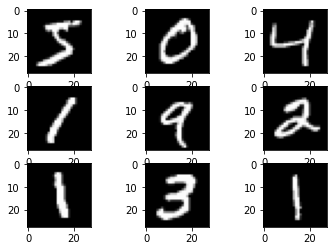


Start of epoch 0
Training acc over epoch: 0.7906
Validation acc: 0.8428

Start of epoch 1
Training acc over epoch: 0.8676
Validation acc: 0.8724

Start of epoch 2
Training acc over epoch: 0.8911
Validation acc: 0.8973

Start of epoch 3
Training acc over epoch: 0.9060
Validation acc: 0.9052

Start of epoch 4
Training acc over epoch: 0.9151
Validation acc: 0.9096

Start of epoch 5
Training acc over epoch: 0.9229
Validation acc: 0.9164

Start of epoch 6
Training acc over epoch: 0.9277
Validation acc: 0.9137


_runtime,77
_timestamp,1622343974
_step,7
epochs,6
loss,0.25925
acc,0.92775
val_loss,0.32271
val_acc,0.9137


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: 4gzif7in with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


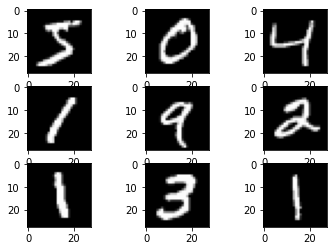


Start of epoch 0
Training acc over epoch: 0.6936
Validation acc: 0.8096

Start of epoch 1
Training acc over epoch: 0.8283
Validation acc: 0.8609

Start of epoch 2
Training acc over epoch: 0.8673
Validation acc: 0.8818

Start of epoch 3
Training acc over epoch: 0.8849
Validation acc: 0.8958

Start of epoch 4
Training acc over epoch: 0.8966
Validation acc: 0.8915

Start of epoch 5
Training acc over epoch: 0.9056
Validation acc: 0.9060

Start of epoch 6
Training acc over epoch: 0.9107
Validation acc: 0.9103


_runtime,77
_timestamp,1622344059
_step,7
epochs,6
loss,0.3197
acc,0.91075
val_loss,0.36622
val_acc,0.9103


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▃▂▁▁▁▁
acc,▁▅▇▇███
val_loss,█▅▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: 2b9bwsdw with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


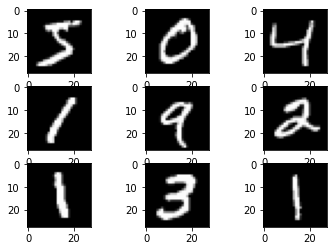


Start of epoch 0
Training acc over epoch: 0.7515
Validation acc: 0.8431

Start of epoch 1
Training acc over epoch: 0.8537
Validation acc: 0.8723

Start of epoch 2
Training acc over epoch: 0.8821
Validation acc: 0.8889

Start of epoch 3
Training acc over epoch: 0.8988
Validation acc: 0.8998

Start of epoch 4
Training acc over epoch: 0.9085
Validation acc: 0.9060

Start of epoch 5
Training acc over epoch: 0.9164
Validation acc: 0.9103

Start of epoch 6
Training acc over epoch: 0.9211
Validation acc: 0.9133


_runtime,77
_timestamp,1622344144
_step,7
epochs,6
loss,0.26832
acc,0.9211
val_loss,0.34118
val_acc,0.9133


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: hkr0vmkr with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


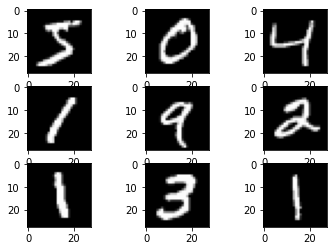


Start of epoch 0
Training acc over epoch: 0.8181
Validation acc: 0.8767

Start of epoch 1
Training acc over epoch: 0.8906
Validation acc: 0.9047

Start of epoch 2
Training acc over epoch: 0.9113
Validation acc: 0.9051

Start of epoch 3
Training acc over epoch: 0.9236
Validation acc: 0.9175

Start of epoch 4
Training acc over epoch: 0.9316
Validation acc: 0.9211

Start of epoch 5
Training acc over epoch: 0.9366
Validation acc: 0.9254

Start of epoch 6
Training acc over epoch: 0.9404
Validation acc: 0.9288


_runtime,77
_timestamp,1622344228
_step,7
epochs,6
loss,0.20545
acc,0.94037
val_loss,0.26037
val_acc,0.9288


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇███
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▅▆▇██


wandb: Agent Starting Run: php8w2z1 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


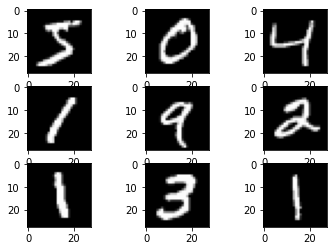


Start of epoch 0
Training acc over epoch: 0.8130
Validation acc: 0.8700

Start of epoch 1
Training acc over epoch: 0.8844
Validation acc: 0.8984

Start of epoch 2
Training acc over epoch: 0.9061
Validation acc: 0.9070

Start of epoch 3
Training acc over epoch: 0.9170
Validation acc: 0.9156

Start of epoch 4
Training acc over epoch: 0.9263
Validation acc: 0.9128

Start of epoch 5
Training acc over epoch: 0.9316
Validation acc: 0.9213

Start of epoch 6
Training acc over epoch: 0.9368
Validation acc: 0.9238


_runtime,84
_timestamp,1622344319
_step,7
epochs,6
loss,0.22881
acc,0.93682
val_loss,0.3026
val_acc,0.9238


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: iysvf1th with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


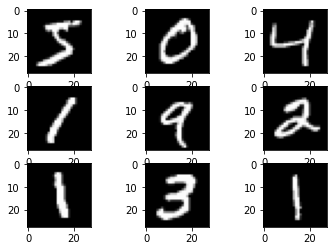


Start of epoch 0
Training acc over epoch: 0.7706
Validation acc: 0.8595

Start of epoch 1
Training acc over epoch: 0.8680
Validation acc: 0.8849

Start of epoch 2
Training acc over epoch: 0.8946
Validation acc: 0.8974

Start of epoch 3
Training acc over epoch: 0.9082
Validation acc: 0.9068

Start of epoch 4


_runtime,47
_timestamp,1622344375
_step,4
epochs,3
loss,0.32968
acc,0.9082
val_loss,0.34893
val_acc,0.9068


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▂▁
val_acc,▁▅▇█


wandb: Agent Starting Run: tesuq15c with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


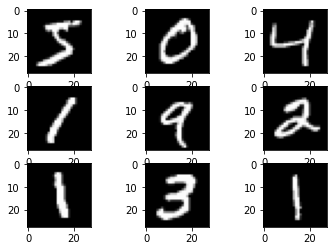


Start of epoch 0
Training acc over epoch: 0.7627
Validation acc: 0.8267

Start of epoch 1
Training acc over epoch: 0.8566
Validation acc: 0.8678

Start of epoch 2
Training acc over epoch: 0.8850
Validation acc: 0.8893

Start of epoch 3
Training acc over epoch: 0.9017
Validation acc: 0.9015

Start of epoch 4


_runtime,47
_timestamp,1622344437
_step,4
epochs,3
loss,0.36489
acc,0.90172
val_loss,0.40474
val_acc,0.9015


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▂▁
val_acc,▁▅▇█


wandb: Agent Starting Run: vitw0f36 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


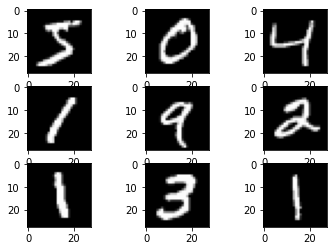


Start of epoch 0
Training acc over epoch: 0.8291
Validation acc: 0.8750

Start of epoch 1
Training acc over epoch: 0.8950
Validation acc: 0.9018

Start of epoch 2
Training acc over epoch: 0.9137
Validation acc: 0.9113

Start of epoch 3
Training acc over epoch: 0.9257
Validation acc: 0.9174

Start of epoch 4
Training acc over epoch: 0.9327
Validation acc: 0.9219

Start of epoch 5
Training acc over epoch: 0.9372
Validation acc: 0.9267

Start of epoch 6
Training acc over epoch: 0.9420
Validation acc: 0.9300


_runtime,78
_timestamp,1622344527
_step,7
epochs,6
loss,0.19897
acc,0.94198
val_loss,0.27877
val_acc,0.93


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▆▇██


wandb: Agent Starting Run: f3r168lt with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


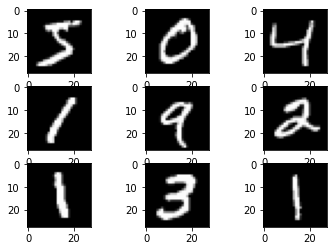


Start of epoch 0
Training acc over epoch: 0.7739
Validation acc: 0.8583

Start of epoch 1
Training acc over epoch: 0.8678
Validation acc: 0.8862

Start of epoch 2
Training acc over epoch: 0.8944
Validation acc: 0.8952

Start of epoch 3
Training acc over epoch: 0.9075
Validation acc: 0.9008

Start of epoch 4
Training acc over epoch: 0.9161
Validation acc: 0.9122

Start of epoch 5
Training acc over epoch: 0.9223
Validation acc: 0.9142

Start of epoch 6
Training acc over epoch: 0.9265
Validation acc: 0.9218


_runtime,78
_timestamp,1622344612
_step,7
epochs,6
loss,0.26104
acc,0.92648
val_loss,0.30713
val_acc,0.9218


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▇▇███
val_loss,█▅▄▃▂▂▁
val_acc,▁▄▅▆▇▇█


wandb: Agent Starting Run: icdc4yx9 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


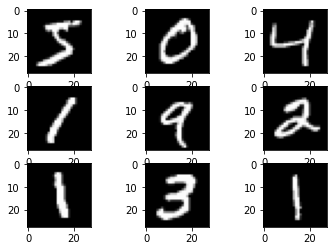


Start of epoch 0
Training acc over epoch: 0.7975
Validation acc: 0.8615

Start of epoch 1
Training acc over epoch: 0.8788
Validation acc: 0.8888

Start of epoch 2
Training acc over epoch: 0.9017
Validation acc: 0.9042

Start of epoch 3
Training acc over epoch: 0.9147
Validation acc: 0.9139

Start of epoch 4
Training acc over epoch: 0.9235
Validation acc: 0.9110

Start of epoch 5
Training acc over epoch: 0.9295
Validation acc: 0.9205

Start of epoch 6
Training acc over epoch: 0.9347
Validation acc: 0.9224


_runtime,77
_timestamp,1622344697
_step,7
epochs,6
loss,0.22871
acc,0.93472
val_loss,0.29484
val_acc,0.9224


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: q1gomnks with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


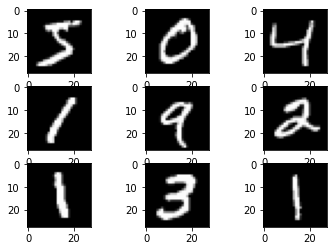


Start of epoch 0
Training acc over epoch: 0.7802
Validation acc: 0.8493

Start of epoch 1
Training acc over epoch: 0.8692
Validation acc: 0.8849

Start of epoch 2
Training acc over epoch: 0.8931
Validation acc: 0.8960

Start of epoch 3
Training acc over epoch: 0.9072
Validation acc: 0.9076

Start of epoch 4
Training acc over epoch: 0.9176
Validation acc: 0.9093

Start of epoch 5
Training acc over epoch: 0.9236
Validation acc: 0.9165

Start of epoch 6
Training acc over epoch: 0.9293
Validation acc: 0.9190


_runtime,77
_timestamp,1622344783
_step,7
epochs,6
loss,0.25265
acc,0.9293
val_loss,0.32434
val_acc,0.919


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: 5vpcgroj with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


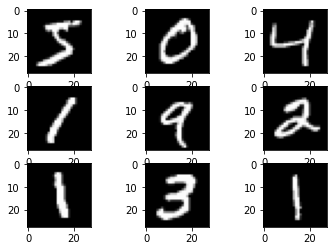


Start of epoch 0
Training acc over epoch: 0.7632
Validation acc: 0.8437

Start of epoch 1
Training acc over epoch: 0.8538
Validation acc: 0.8767

Start of epoch 2
Training acc over epoch: 0.8834
Validation acc: 0.8922

Start of epoch 3
Training acc over epoch: 0.8988
Validation acc: 0.8985

Start of epoch 4
Training acc over epoch: 0.9101
Validation acc: 0.9051

Start of epoch 5
Training acc over epoch: 0.9191
Validation acc: 0.9157

Start of epoch 6
Training acc over epoch: 0.9250
Validation acc: 0.9126


_runtime,79
_timestamp,1622344869
_step,7
epochs,6
loss,0.26712
acc,0.92502
val_loss,0.33878
val_acc,0.9126


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▃▂▁▁
val_acc,▁▄▆▆▇██


wandb: Agent Starting Run: flywzwfd with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


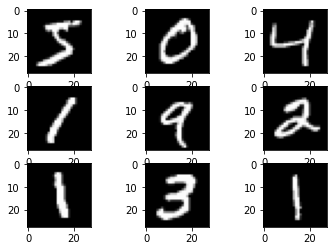


Start of epoch 0
Training acc over epoch: 0.7953
Validation acc: 0.8597

Start of epoch 1
Training acc over epoch: 0.8791
Validation acc: 0.8929

Start of epoch 2
Training acc over epoch: 0.9021
Validation acc: 0.9058

Start of epoch 3
Training acc over epoch: 0.9152
Validation acc: 0.9149

Start of epoch 4
Training acc over epoch: 0.9236
Validation acc: 0.9199

Start of epoch 5
Training acc over epoch: 0.9293
Validation acc: 0.9245

Start of epoch 6
Training acc over epoch: 0.9344
Validation acc: 0.9283


_runtime,79
_timestamp,1622344956
_step,7
epochs,6
loss,0.23403
acc,0.93435
val_loss,0.27774
val_acc,0.9283


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: dbdkug0b with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


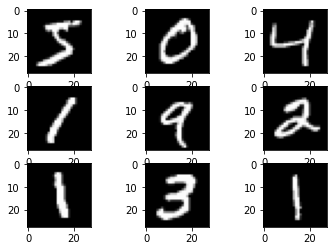


Start of epoch 0
Training acc over epoch: 0.6836
Validation acc: 0.7881

Start of epoch 1
Training acc over epoch: 0.8156
Validation acc: 0.8569

Start of epoch 2
Training acc over epoch: 0.8661
Validation acc: 0.8845

Start of epoch 3
Training acc over epoch: 0.8857
Validation acc: 0.8982

Start of epoch 4
Training acc over epoch: 0.8994
Validation acc: 0.9040

Start of epoch 5
Training acc over epoch: 0.9084
Validation acc: 0.9088

Start of epoch 6
Training acc over epoch: 0.9147
Validation acc: 0.9131


_runtime,78
_timestamp,1622345041
_step,7
epochs,6
loss,0.31478
acc,0.91468
val_loss,0.3571
val_acc,0.9131


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
acc,▁▅▇▇███
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: 2p08q1jq with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


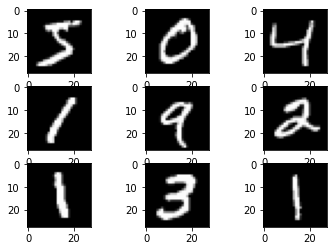


Start of epoch 0
Training acc over epoch: 0.7962
Validation acc: 0.8596

Start of epoch 1
Training acc over epoch: 0.8731
Validation acc: 0.8898

Start of epoch 2
Training acc over epoch: 0.8970
Validation acc: 0.9044

Start of epoch 3
Training acc over epoch: 0.9104
Validation acc: 0.9074

Start of epoch 4
Training acc over epoch: 0.9186
Validation acc: 0.9105

Start of epoch 5
Training acc over epoch: 0.9250
Validation acc: 0.9184

Start of epoch 6
Training acc over epoch: 0.9292
Validation acc: 0.9164


_runtime,78
_timestamp,1622345127
_step,7
epochs,6
loss,0.25116
acc,0.92922
val_loss,0.32346
val_acc,0.9164


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: eiyyxpt3 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


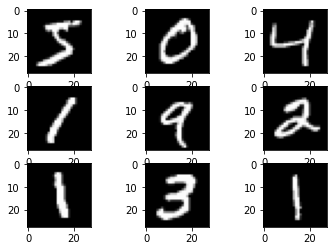


Start of epoch 0
Training acc over epoch: 0.8099
Validation acc: 0.8755

Start of epoch 1
Training acc over epoch: 0.8875
Validation acc: 0.8962

Start of epoch 2
Training acc over epoch: 0.9086
Validation acc: 0.9139

Start of epoch 3
Training acc over epoch: 0.9211
Validation acc: 0.9196

Start of epoch 4
Training acc over epoch: 0.9275
Validation acc: 0.9216

Start of epoch 5
Training acc over epoch: 0.9343
Validation acc: 0.9282

Start of epoch 6
Training acc over epoch: 0.9385
Validation acc: 0.9307


_runtime,78
_timestamp,1622345212
_step,7
epochs,6
loss,0.21762
acc,0.93853
val_loss,0.26209
val_acc,0.9307


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: hvuu3owz with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


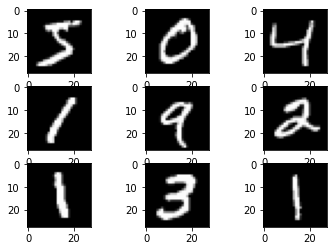


Start of epoch 0
Training acc over epoch: 0.7753
Validation acc: 0.8380

Start of epoch 1
Training acc over epoch: 0.8673
Validation acc: 0.8722

Start of epoch 2
Training acc over epoch: 0.8935
Validation acc: 0.8930

Start of epoch 3
Training acc over epoch: 0.9075
Validation acc: 0.9041

Start of epoch 4
Training acc over epoch: 0.9168
Validation acc: 0.9126

Start of epoch 5
Training acc over epoch: 0.9240
Validation acc: 0.9128

Start of epoch 6
Training acc over epoch: 0.9295
Validation acc: 0.9188


_runtime,78
_timestamp,1622345298
_step,7
epochs,6
loss,0.25149
acc,0.92953
val_loss,0.30647
val_acc,0.9188


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▁▁▁
val_acc,▁▄▆▇▇▇█


wandb: Agent Starting Run: 9zh2scwk with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


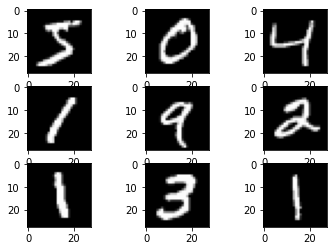


Start of epoch 0
Training acc over epoch: 0.8069
Validation acc: 0.8695

Start of epoch 1
Training acc over epoch: 0.8815
Validation acc: 0.8896

Start of epoch 2
Training acc over epoch: 0.9038
Validation acc: 0.9059

Start of epoch 3
Training acc over epoch: 0.9151
Validation acc: 0.9088

Start of epoch 4
Training acc over epoch: 0.9244
Validation acc: 0.9196

Start of epoch 5
Training acc over epoch: 0.9306
Validation acc: 0.9179

Start of epoch 6
Training acc over epoch: 0.9346
Validation acc: 0.9248


_runtime,79
_timestamp,1622345385
_step,7
epochs,6
loss,0.22987
acc,0.93458
val_loss,0.28331
val_acc,0.9248


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▂▁
val_acc,▁▄▆▆▇▇█


wandb: Agent Starting Run: 4cuv1jn3 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


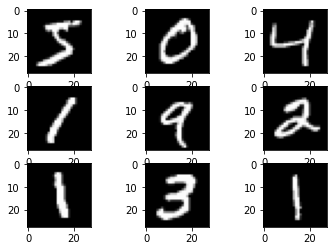


Start of epoch 0
Training acc over epoch: 0.7916
Validation acc: 0.8516

Start of epoch 1
Training acc over epoch: 0.8691
Validation acc: 0.8829

Start of epoch 2
Training acc over epoch: 0.8936
Validation acc: 0.8973

Start of epoch 3
Training acc over epoch: 0.9092
Validation acc: 0.9093

Start of epoch 4
Training acc over epoch: 0.9185
Validation acc: 0.9134

Start of epoch 5
Training acc over epoch: 0.9253
Validation acc: 0.9157

Start of epoch 6
Training acc over epoch: 0.9311
Validation acc: 0.9236


_runtime,78
_timestamp,1622345471
_step,7
epochs,6
loss,0.2352
acc,0.93108
val_loss,0.29529
val_acc,0.9236


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▂▁
val_acc,▁▄▅▇▇▇█


wandb: Agent Starting Run: c9sl0wg2 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


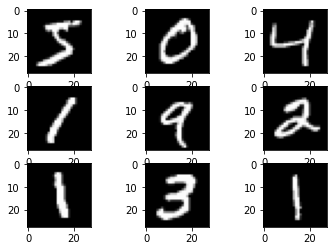


Start of epoch 0
Training acc over epoch: 0.7882
Validation acc: 0.8562

Start of epoch 1
Training acc over epoch: 0.8712
Validation acc: 0.8749

Start of epoch 2
Training acc over epoch: 0.8956
Validation acc: 0.8946

Start of epoch 3
Training acc over epoch: 0.9083
Validation acc: 0.9048

Start of epoch 4
Training acc over epoch: 0.9167
Validation acc: 0.9097

Start of epoch 5
Training acc over epoch: 0.9233
Validation acc: 0.9133

Start of epoch 6


_runtime,103
_timestamp,1622345582
_step,6
epochs,5
loss,0.27915
acc,0.92325
val_loss,0.36387
val_acc,0.9133


_runtime,▁▂▃▃▆▇█
_timestamp,▁▂▃▃▆▇█
_step,▁▂▃▅▆▇█
epochs,▁▂▄▅▇█
loss,█▂▂▁▁▁
acc,▁▅▇▇██
val_loss,█▄▃▂▁▁
val_acc,▁▃▆▇██


wandb: Agent Starting Run: 40cujewk with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


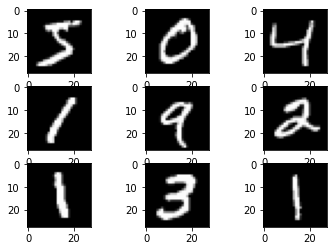


Start of epoch 0
Training acc over epoch: 0.8072
Validation acc: 0.8736

Start of epoch 1
Training acc over epoch: 0.8826
Validation acc: 0.8962

Start of epoch 2
Training acc over epoch: 0.9059
Validation acc: 0.9103

Start of epoch 3
Training acc over epoch: 0.9182
Validation acc: 0.9173

Start of epoch 4
Training acc over epoch: 0.9252
Validation acc: 0.9196

Start of epoch 5
Training acc over epoch: 0.9312
Validation acc: 0.9271

Start of epoch 6
Training acc over epoch: 0.9361
Validation acc: 0.9296


_runtime,90
_timestamp,1622345683
_step,7
epochs,6
loss,0.22374
acc,0.9361
val_loss,0.27875
val_acc,0.9296


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▆▇██


wandb: Agent Starting Run: waatxql8 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


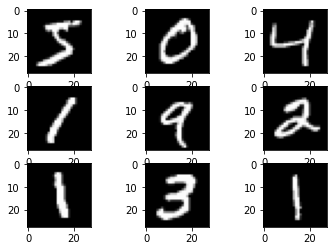


Start of epoch 0
Training acc over epoch: 0.7821
Validation acc: 0.8607

Start of epoch 1
Training acc over epoch: 0.8706
Validation acc: 0.8808

Start of epoch 2
Training acc over epoch: 0.8976
Validation acc: 0.8954

Start of epoch 3
Training acc over epoch: 0.9112
Validation acc: 0.9101

Start of epoch 4
Training acc over epoch: 0.9208
Validation acc: 0.9101

Start of epoch 5
Training acc over epoch: 0.9264
Validation acc: 0.9176

Start of epoch 6


_runtime,76
_timestamp,1622345767
_step,6
epochs,5
loss,0.26262
acc,0.9264
val_loss,0.34035
val_acc,0.9176


_runtime,▁▂▃▄▅▇█
_timestamp,▁▂▃▄▅▇█
_step,▁▂▃▅▆▇█
epochs,▁▂▄▅▇█
loss,█▂▂▁▁▁
acc,▁▅▇▇██
val_loss,█▅▃▂▁▁
val_acc,▁▃▅▇▇█


wandb: Agent Starting Run: tuahztix with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


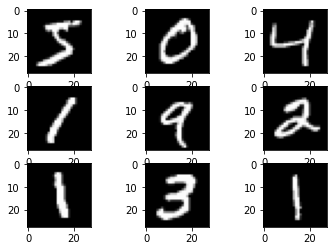


Start of epoch 0
Training acc over epoch: 0.8036
Validation acc: 0.8667

Start of epoch 1
Training acc over epoch: 0.8804
Validation acc: 0.8917

Start of epoch 2
Training acc over epoch: 0.9033
Validation acc: 0.9050

Start of epoch 3
Training acc over epoch: 0.9153
Validation acc: 0.9127

Start of epoch 4
Training acc over epoch: 0.9243
Validation acc: 0.9182

Start of epoch 5
Training acc over epoch: 0.9290
Validation acc: 0.9190

Start of epoch 6
Training acc over epoch: 0.9334
Validation acc: 0.9247


_runtime,80
_timestamp,1622345854
_step,7
epochs,6
loss,0.22763
acc,0.93345
val_loss,0.28917
val_acc,0.9247


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇███
val_loss,█▄▃▂▁▁▁
val_acc,▁▄▆▇▇▇█


wandb: Agent Starting Run: 2u46760r with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


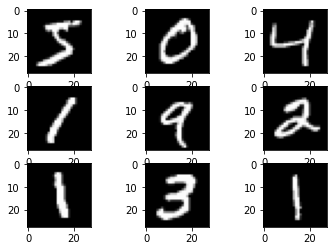


Start of epoch 0
Training acc over epoch: 0.7409
Validation acc: 0.8403

Start of epoch 1
Training acc over epoch: 0.8631
Validation acc: 0.8802

Start of epoch 2
Training acc over epoch: 0.8925
Validation acc: 0.9021

Start of epoch 3
Training acc over epoch: 0.9097
Validation acc: 0.9085

Start of epoch 4
Training acc over epoch: 0.9173
Validation acc: 0.9166

Start of epoch 5
Training acc over epoch: 0.9255
Validation acc: 0.9204

Start of epoch 6
Training acc over epoch: 0.9301
Validation acc: 0.9238


_runtime,80
_timestamp,1622345942
_step,7
epochs,6
loss,0.2459
acc,0.93005
val_loss,0.2721
val_acc,0.9238


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▆▇▇███
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: 73j91rrl with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


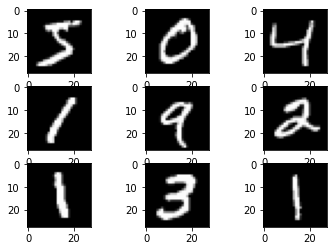


Start of epoch 0
Training acc over epoch: 0.7942
Validation acc: 0.8535

Start of epoch 1
Training acc over epoch: 0.8796
Validation acc: 0.8920

Start of epoch 2
Training acc over epoch: 0.9021
Validation acc: 0.9049

Start of epoch 3
Training acc over epoch: 0.9152
Validation acc: 0.9087

Start of epoch 4
Training acc over epoch: 0.9227
Validation acc: 0.9159

Start of epoch 5
Training acc over epoch: 0.9298
Validation acc: 0.9166

Start of epoch 6
Training acc over epoch: 0.9346
Validation acc: 0.9227


_runtime,81
_timestamp,1622346030
_step,7
epochs,6
loss,0.22895
acc,0.93463
val_loss,0.31036
val_acc,0.9227


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▁▁▁
val_acc,▁▅▆▇▇▇█


wandb: Agent Starting Run: k53lhrq8 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


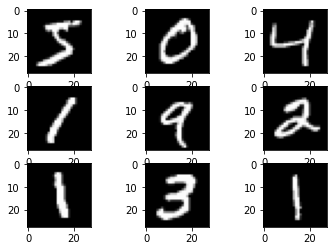


Start of epoch 0
Training acc over epoch: 0.7969
Validation acc: 0.8683

Start of epoch 1
Training acc over epoch: 0.8795
Validation acc: 0.8972

Start of epoch 2
Training acc over epoch: 0.9014
Validation acc: 0.9060

Start of epoch 3
Training acc over epoch: 0.9128
Validation acc: 0.9151

Start of epoch 4
Training acc over epoch: 0.9213
Validation acc: 0.9218

Start of epoch 5
Training acc over epoch: 0.9263
Validation acc: 0.9245

Start of epoch 6
Training acc over epoch: 0.9318
Validation acc: 0.9260


_runtime,80
_timestamp,1622346118
_step,7
epochs,6
loss,0.23268
acc,0.9318
val_loss,0.27437
val_acc,0.926


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: xy00vawi with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


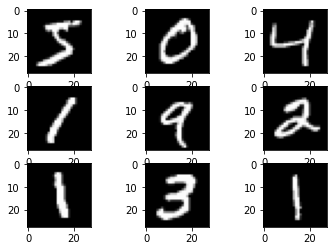


Start of epoch 0
Training acc over epoch: 0.7908
Validation acc: 0.8276

Start of epoch 1
Training acc over epoch: 0.8662
Validation acc: 0.8854

Start of epoch 2
Training acc over epoch: 0.8932
Validation acc: 0.8898

Start of epoch 3
Training acc over epoch: 0.9087
Validation acc: 0.8944

Start of epoch 4
Training acc over epoch: 0.9181
Validation acc: 0.9171

Start of epoch 5
Training acc over epoch: 0.9249
Validation acc: 0.9202

Start of epoch 6
Training acc over epoch: 0.9301
Validation acc: 0.9197


_runtime,81
_timestamp,1622346207
_step,7
epochs,6
loss,0.23984
acc,0.93012
val_loss,0.30504
val_acc,0.9197


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▃▃▂▁▁▁
val_acc,▁▅▆▆███


wandb: Agent Starting Run: b8mn0udv with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


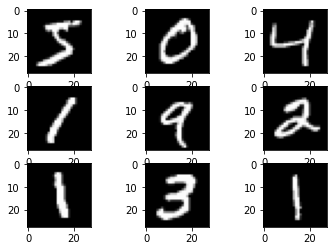


Start of epoch 0
Training acc over epoch: 0.7331
Validation acc: 0.8244

Start of epoch 1
Training acc over epoch: 0.8446
Validation acc: 0.8631

Start of epoch 2
Training acc over epoch: 0.8744
Validation acc: 0.8821

Start of epoch 3
Training acc over epoch: 0.8919
Validation acc: 0.8959

Start of epoch 4
Training acc over epoch: 0.9043
Validation acc: 0.9021

Start of epoch 5
Training acc over epoch: 0.9109
Validation acc: 0.9045

Start of epoch 6
Training acc over epoch: 0.9189
Validation acc: 0.9102


_runtime,81
_timestamp,1622346295
_step,7
epochs,6
loss,0.29717
acc,0.91892
val_loss,0.35426
val_acc,0.9102


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: giowokfl with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


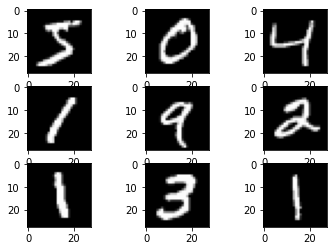


Start of epoch 0
Training acc over epoch: 0.7421
Validation acc: 0.8251

Start of epoch 1
Training acc over epoch: 0.8519
Validation acc: 0.8703

Start of epoch 2
Training acc over epoch: 0.8836
Validation acc: 0.8899

Start of epoch 3
Training acc over epoch: 0.9002
Validation acc: 0.9020

Start of epoch 4
Training acc over epoch: 0.9102
Validation acc: 0.9122

Start of epoch 5
Training acc over epoch: 0.9193
Validation acc: 0.9161

Start of epoch 6
Training acc over epoch: 0.9247
Validation acc: 0.9186


_runtime,80
_timestamp,1622346383
_step,7
epochs,6
loss,0.27925
acc,0.9247
val_loss,0.35358
val_acc,0.9186


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇███


wandb: Agent Starting Run: 71h8mcxk with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


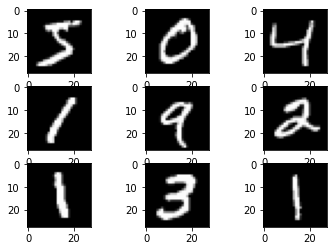


Start of epoch 0
Training acc over epoch: 0.7324
Validation acc: 0.8320

Start of epoch 1
Training acc over epoch: 0.8460
Validation acc: 0.8700

Start of epoch 2
Training acc over epoch: 0.8793
Validation acc: 0.8854

Start of epoch 3
Training acc over epoch: 0.8977
Validation acc: 0.9027

Start of epoch 4
Training acc over epoch: 0.9100
Validation acc: 0.9072

Start of epoch 5
Training acc over epoch: 0.9177
Validation acc: 0.9127

Start of epoch 6
Training acc over epoch: 0.9230
Validation acc: 0.9174


_runtime,81
_timestamp,1622346472
_step,7
epochs,6
loss,0.27594
acc,0.92297
val_loss,0.32153
val_acc,0.9174


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
acc,▁▅▆▇███
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▅▇▇██


wandb: Agent Starting Run: 8z9duq3z with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


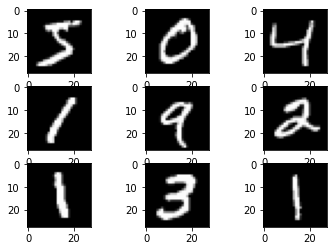


Start of epoch 0
Training acc over epoch: 0.7904
Validation acc: 0.8569

Start of epoch 1
Training acc over epoch: 0.8812
Validation acc: 0.8977

Start of epoch 2
Training acc over epoch: 0.9040
Validation acc: 0.9078

Start of epoch 3
Training acc over epoch: 0.9160
Validation acc: 0.9166

Start of epoch 4
Training acc over epoch: 0.9239
Validation acc: 0.9195

Start of epoch 5
Training acc over epoch: 0.9301
Validation acc: 0.9259

Start of epoch 6
Training acc over epoch: 0.9349
Validation acc: 0.9290


_runtime,79
_timestamp,1622346560
_step,7
epochs,6
loss,0.22524
acc,0.93488
val_loss,0.24553
val_acc,0.929


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▇▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: 7fabqs6l with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


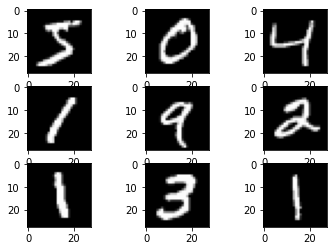


Start of epoch 0
Training acc over epoch: 0.8098
Validation acc: 0.8681

Start of epoch 1
Training acc over epoch: 0.8793
Validation acc: 0.8841

Start of epoch 2
Training acc over epoch: 0.9020
Validation acc: 0.9045

Start of epoch 3
Training acc over epoch: 0.9150
Validation acc: 0.9128

Start of epoch 4
Training acc over epoch: 0.9253
Validation acc: 0.9135

Start of epoch 5
Training acc over epoch: 0.9303
Validation acc: 0.9197

Start of epoch 6
Training acc over epoch: 0.9356
Validation acc: 0.9225


_runtime,80
_timestamp,1622346648
_step,7
epochs,6
loss,0.22961
acc,0.93565
val_loss,0.31863
val_acc,0.9225


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▂▁
val_acc,▁▃▆▇▇██


wandb: Agent Starting Run: 8vgolsup with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


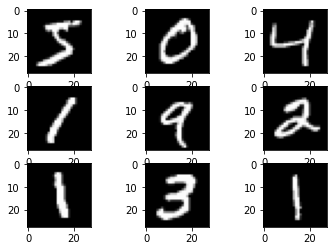


Start of epoch 0
Training acc over epoch: 0.7772
Validation acc: 0.8449

Start of epoch 1
Training acc over epoch: 0.8697
Validation acc: 0.8839

Start of epoch 2
Training acc over epoch: 0.8969
Validation acc: 0.9040

Start of epoch 3
Training acc over epoch: 0.9107
Validation acc: 0.9119

Start of epoch 4
Training acc over epoch: 0.9201
Validation acc: 0.9135

Start of epoch 5
Training acc over epoch: 0.9268
Validation acc: 0.9217

Start of epoch 6
Training acc over epoch: 0.9319
Validation acc: 0.9271


_runtime,84
_timestamp,1622346739
_step,7
epochs,6
loss,0.23283
acc,0.93188
val_loss,0.26735
val_acc,0.9271


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: 2nhf36b5 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


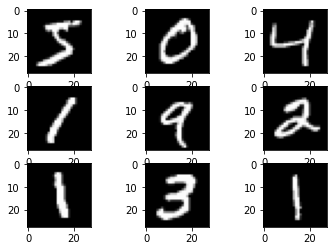


Start of epoch 0
Training acc over epoch: 0.7620
Validation acc: 0.8497

Start of epoch 1
Training acc over epoch: 0.8637
Validation acc: 0.8774

Start of epoch 2
Training acc over epoch: 0.8890
Validation acc: 0.8959

Start of epoch 3
Training acc over epoch: 0.9017
Validation acc: 0.8995

Start of epoch 4
Training acc over epoch: 0.9093
Validation acc: 0.9051

Start of epoch 5
Training acc over epoch: 0.9166
Validation acc: 0.9121

Start of epoch 6
Training acc over epoch: 0.9211
Validation acc: 0.9151


_runtime,80
_timestamp,1622346828
_step,7
epochs,6
loss,0.28414
acc,0.92107
val_loss,0.33641
val_acc,0.9151


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▇▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▆▇██


wandb: Agent Starting Run: cdyjz3th with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


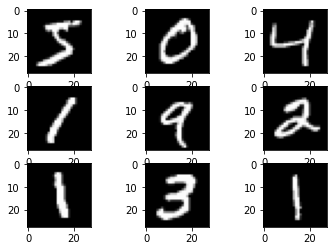


Start of epoch 0
Training acc over epoch: 0.7911
Validation acc: 0.8380

Start of epoch 1
Training acc over epoch: 0.8737
Validation acc: 0.8871

Start of epoch 2
Training acc over epoch: 0.8982
Validation acc: 0.8964

Start of epoch 3
Training acc over epoch: 0.9108
Validation acc: 0.9056

Start of epoch 4
Training acc over epoch: 0.9207
Validation acc: 0.9094

Start of epoch 5
Training acc over epoch: 0.9277
Validation acc: 0.9165

Start of epoch 6
Training acc over epoch: 0.9318
Validation acc: 0.9142


_runtime,80
_timestamp,1622346916
_step,7
epochs,6
loss,0.23119
acc,0.93178
val_loss,0.31564
val_acc,0.9142


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▁▁▁
val_acc,▁▅▆▇▇██


wandb: Agent Starting Run: 3beeq6br with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


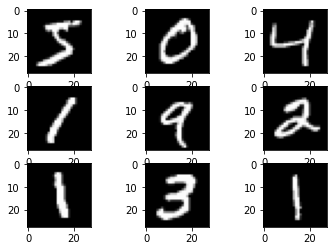


Start of epoch 0
Training acc over epoch: 0.7639
Validation acc: 0.8468

Start of epoch 1
Training acc over epoch: 0.8627
Validation acc: 0.8753

Start of epoch 2
Training acc over epoch: 0.8868
Validation acc: 0.8878

Start of epoch 3
Training acc over epoch: 0.9005
Validation acc: 0.9005

Start of epoch 4
Training acc over epoch: 0.9088
Validation acc: 0.9060

Start of epoch 5
Training acc over epoch: 0.9156
Validation acc: 0.9102

Start of epoch 6
Training acc over epoch: 0.9210
Validation acc: 0.9137


_runtime,81
_timestamp,1622347005
_step,7
epochs,6
loss,0.28407
acc,0.92103
val_loss,0.3352
val_acc,0.9137


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▅▇▇██


wandb: Agent Starting Run: btnjmz2u with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


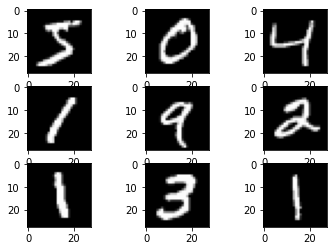


Start of epoch 0
Training acc over epoch: 0.7860
Validation acc: 0.8582

Start of epoch 1
Training acc over epoch: 0.8725
Validation acc: 0.8846

Start of epoch 2
Training acc over epoch: 0.8970
Validation acc: 0.9047

Start of epoch 3
Training acc over epoch: 0.9086
Validation acc: 0.9083

Start of epoch 4
Training acc over epoch: 0.9176
Validation acc: 0.9111

Start of epoch 5
Training acc over epoch: 0.9232
Validation acc: 0.9201

Start of epoch 6
Training acc over epoch: 0.9286
Validation acc: 0.9219


_runtime,81
_timestamp,1622347094
_step,7
epochs,6
loss,0.25376
acc,0.9286
val_loss,0.29539
val_acc,0.9219


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: j6296zub with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


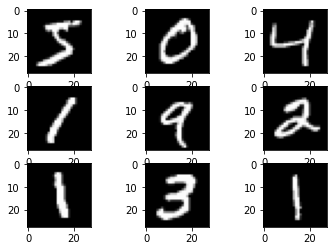


Start of epoch 0
Training acc over epoch: 0.8008
Validation acc: 0.8581

Start of epoch 1
Training acc over epoch: 0.8759
Validation acc: 0.8912

Start of epoch 2
Training acc over epoch: 0.9017
Validation acc: 0.8979

Start of epoch 3
Training acc over epoch: 0.9152
Validation acc: 0.9101

Start of epoch 4
Training acc over epoch: 0.9251
Validation acc: 0.9161

Start of epoch 5
Training acc over epoch: 0.9310
Validation acc: 0.9249

Start of epoch 6
Training acc over epoch: 0.9366
Validation acc: 0.9298


_runtime,80
_timestamp,1622347182
_step,7
epochs,6
loss,0.22298
acc,0.9366
val_loss,0.26829
val_acc,0.9298


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▃▂▁▁
val_acc,▁▄▅▆▇██


wandb: Agent Starting Run: x99c0e3w with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


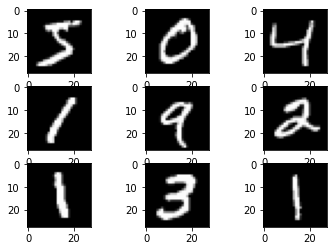


Start of epoch 0
Training acc over epoch: 0.8051
Validation acc: 0.8636

Start of epoch 1
Training acc over epoch: 0.8767
Validation acc: 0.8871

Start of epoch 2
Training acc over epoch: 0.9015
Validation acc: 0.9013

Start of epoch 3
Training acc over epoch: 0.9143
Validation acc: 0.9108

Start of epoch 4
Training acc over epoch: 0.9226
Validation acc: 0.9189

Start of epoch 5
Training acc over epoch: 0.9297
Validation acc: 0.9225

Start of epoch 6
Training acc over epoch: 0.9347
Validation acc: 0.9256


_runtime,80
_timestamp,1622347271
_step,7
epochs,6
loss,0.22715
acc,0.93472
val_loss,0.28453
val_acc,0.9256


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▅▆▇██


wandb: Agent Starting Run: stchfrdd with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


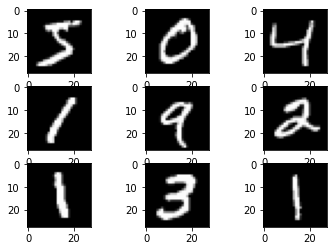


Start of epoch 0
Training acc over epoch: 0.7970
Validation acc: 0.8600

Start of epoch 1
Training acc over epoch: 0.8781
Validation acc: 0.8895

Start of epoch 2
Training acc over epoch: 0.9028
Validation acc: 0.9007

Start of epoch 3
Training acc over epoch: 0.9136
Validation acc: 0.9079

Start of epoch 4
Training acc over epoch: 0.9221
Validation acc: 0.9160

Start of epoch 5
Training acc over epoch: 0.9268
Validation acc: 0.9188

Start of epoch 6
Training acc over epoch: 0.9317
Validation acc: 0.9188


_runtime,80
_timestamp,1622347361
_step,7
epochs,6
loss,0.22834
acc,0.93168
val_loss,0.28408
val_acc,0.9188


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇███
val_loss,█▄▃▂▁▁▁
val_acc,▁▅▆▇███


wandb: Agent Starting Run: 1j0b6pj4 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


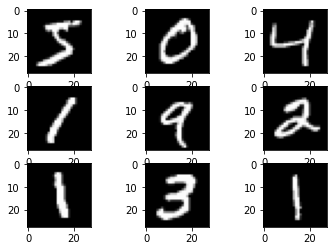


Start of epoch 0
Training acc over epoch: 0.7771
Validation acc: 0.8560

Start of epoch 1
Training acc over epoch: 0.8711
Validation acc: 0.8867

Start of epoch 2
Training acc over epoch: 0.8953
Validation acc: 0.8951

Start of epoch 3
Training acc over epoch: 0.9090
Validation acc: 0.9061

Start of epoch 4
Training acc over epoch: 0.9162
Validation acc: 0.9097

Start of epoch 5
Training acc over epoch: 0.9225
Validation acc: 0.9094

Start of epoch 6
Training acc over epoch: 0.9276
Validation acc: 0.9165


_runtime,80
_timestamp,1622347449
_step,7
epochs,6
loss,0.25688
acc,0.92762
val_loss,0.32638
val_acc,0.9165


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▄▂▂▂▁
val_acc,▁▅▆▇▇▇█


wandb: Agent Starting Run: fzf57qin with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


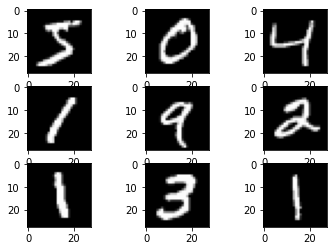


Start of epoch 0
Training acc over epoch: 0.7564
Validation acc: 0.8414

Start of epoch 1
Training acc over epoch: 0.8635
Validation acc: 0.8819

Start of epoch 2
Training acc over epoch: 0.8930
Validation acc: 0.9023

Start of epoch 3
Training acc over epoch: 0.9081
Validation acc: 0.9040

Start of epoch 4
Training acc over epoch: 0.9180
Validation acc: 0.9179

Start of epoch 5
Training acc over epoch: 0.9244
Validation acc: 0.9213

Start of epoch 6
Training acc over epoch: 0.9297
Validation acc: 0.9255


_runtime,80
_timestamp,1622347537
_step,7
epochs,6
loss,0.24324
acc,0.92967
val_loss,0.26166
val_acc,0.9255


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▇▇███
val_loss,█▅▃▃▂▁▁
val_acc,▁▄▆▆▇██


wandb: Agent Starting Run: bg7purv2 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


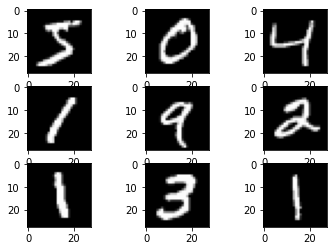


Start of epoch 0
Training acc over epoch: 0.8111
Validation acc: 0.8657

Start of epoch 1
Training acc over epoch: 0.8866
Validation acc: 0.8917

Start of epoch 2
Training acc over epoch: 0.9079
Validation acc: 0.9041

Start of epoch 3
Training acc over epoch: 0.9198
Validation acc: 0.9147

Start of epoch 4
Training acc over epoch: 0.9265
Validation acc: 0.9135

Start of epoch 5
Training acc over epoch: 0.9323
Validation acc: 0.9213

Start of epoch 6
Training acc over epoch: 0.9373
Validation acc: 0.9224


_runtime,80
_timestamp,1622347625
_step,7
epochs,6
loss,0.21838
acc,0.9373
val_loss,0.30156
val_acc,0.9224


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▇▇██


wandb: Agent Starting Run: hnrlrvpr with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


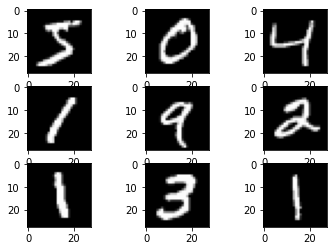


Start of epoch 0
Training acc over epoch: 0.7908
Validation acc: 0.8568

Start of epoch 1
Training acc over epoch: 0.8701
Validation acc: 0.8804

Start of epoch 2
Training acc over epoch: 0.8961
Validation acc: 0.8899

Start of epoch 3
Training acc over epoch: 0.9094
Validation acc: 0.9090

Start of epoch 4


_runtime,50
_timestamp,1622347682
_step,4
epochs,3
loss,0.33181
acc,0.90942
val_loss,0.35679
val_acc,0.909


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▃▁
val_acc,▁▄▅█


wandb: Agent Starting Run: 5p7b4ge6 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


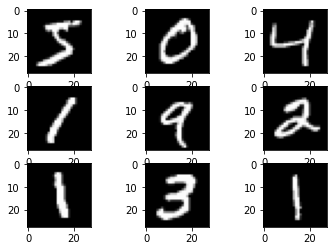


Start of epoch 0
Training acc over epoch: 0.7438
Validation acc: 0.8187

Start of epoch 1
Training acc over epoch: 0.8481
Validation acc: 0.8670

Start of epoch 2
Training acc over epoch: 0.8795
Validation acc: 0.8834

Start of epoch 3
Training acc over epoch: 0.8960
Validation acc: 0.8977

Start of epoch 4


_runtime,49
_timestamp,1622347745
_step,4
epochs,3
loss,0.37869
acc,0.89602
val_loss,0.37986
val_acc,0.8977


_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█
epochs,▁▃▆█
loss,█▂▁▁
acc,▁▆▇█
val_loss,█▄▂▁
val_acc,▁▅▇█


wandb: Agent Starting Run: qm4pusrv with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


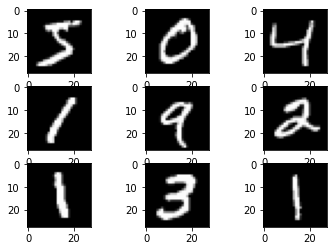


Start of epoch 0
Training acc over epoch: 0.7960
Validation acc: 0.8710

Start of epoch 1
Training acc over epoch: 0.8792
Validation acc: 0.8946

Start of epoch 2
Training acc over epoch: 0.9033
Validation acc: 0.9104

Start of epoch 3
Training acc over epoch: 0.9168
Validation acc: 0.9147

Start of epoch 4
Training acc over epoch: 0.9254
Validation acc: 0.9212

Start of epoch 5
Training acc over epoch: 0.9318
Validation acc: 0.9233

Start of epoch 6
Training acc over epoch: 0.9369
Validation acc: 0.9296


_runtime,80
_timestamp,1622347837
_step,7
epochs,6
loss,0.21787
acc,0.93692
val_loss,0.2583
val_acc,0.9296


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▆▆▇▇█


wandb: Agent Starting Run: ezbsjdkt with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


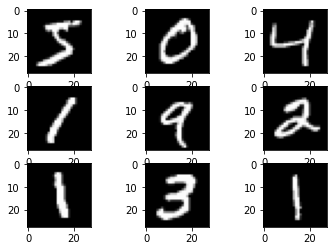


Start of epoch 0
Training acc over epoch: 0.7797
Validation acc: 0.8458

Start of epoch 1
Training acc over epoch: 0.8668
Validation acc: 0.8789

Start of epoch 2
Training acc over epoch: 0.8921
Validation acc: 0.8981

Start of epoch 3
Training acc over epoch: 0.9079
Validation acc: 0.9019

Start of epoch 4
Training acc over epoch: 0.9160
Validation acc: 0.9098

Start of epoch 5
Training acc over epoch: 0.9217
Validation acc: 0.9152

Start of epoch 6
Training acc over epoch: 0.9281
Validation acc: 0.9199


_runtime,81
_timestamp,1622347926
_step,7
epochs,6
loss,0.25396
acc,0.92815
val_loss,0.31194
val_acc,0.9199


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▂▁▁
val_acc,▁▄▆▆▇██


wandb: Agent Starting Run: sk1tpr0l with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


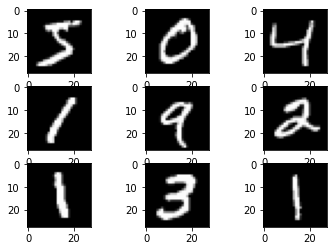


Start of epoch 0
Training acc over epoch: 0.7867
Validation acc: 0.8501

Start of epoch 1
Training acc over epoch: 0.8674
Validation acc: 0.8771

Start of epoch 2
Training acc over epoch: 0.8949
Validation acc: 0.9059

Start of epoch 3
Training acc over epoch: 0.9105
Validation acc: 0.9099

Start of epoch 4
Training acc over epoch: 0.9190
Validation acc: 0.9191

Start of epoch 5
Training acc over epoch: 0.9276
Validation acc: 0.9183

Start of epoch 6
Training acc over epoch: 0.9324
Validation acc: 0.9215


_runtime,2536
_timestamp,1622350469
_step,7
epochs,6
loss,0.23423
acc,0.93243
val_loss,0.29141
val_acc,0.9215


_runtime,▁▁██████
_timestamp,▁▁██████
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▁▁▁
val_acc,▁▄▆▇███


wandb: Agent Starting Run: crku85vp with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


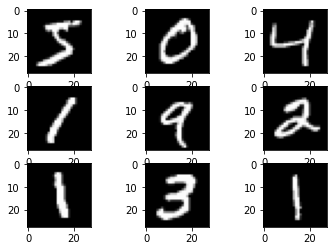


Start of epoch 0
Training acc over epoch: 0.8083
Validation acc: 0.8677

Start of epoch 1
Training acc over epoch: 0.8816
Validation acc: 0.8942

Start of epoch 2
Training acc over epoch: 0.9041
Validation acc: 0.9034

Start of epoch 3
Training acc over epoch: 0.9173
Validation acc: 0.9103

Start of epoch 4
Training acc over epoch: 0.9251
Validation acc: 0.9197

Start of epoch 5
Training acc over epoch: 0.9310
Validation acc: 0.9225

Start of epoch 6
Training acc over epoch: 0.9365
Validation acc: 0.9239


_runtime,74
_timestamp,1622350552
_step,7
epochs,6
loss,0.21971
acc,0.9365
val_loss,0.29219
val_acc,0.9239


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▄▃▂▁▁▁
val_acc,▁▄▅▆▇██


wandb: Agent Starting Run: yu7dbp1t with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


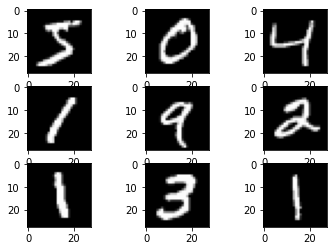


Start of epoch 0
Training acc over epoch: 0.7868
Validation acc: 0.8665

Start of epoch 1
Training acc over epoch: 0.8775
Validation acc: 0.8939

Start of epoch 2
Training acc over epoch: 0.9019
Validation acc: 0.9087

Start of epoch 3
Training acc over epoch: 0.9152
Validation acc: 0.9188

Start of epoch 4
Training acc over epoch: 0.9232
Validation acc: 0.9269

Start of epoch 5
Training acc over epoch: 0.9299
Validation acc: 0.9293

Start of epoch 6
Training acc over epoch: 0.9340
Validation acc: 0.9302


_runtime,73
_timestamp,1622350633
_step,7
epochs,6
loss,0.2243
acc,0.93395
val_loss,0.26485
val_acc,0.9302


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▁▁▁
val_acc,▁▄▆▇███


wandb: Agent Starting Run: dmguv0zd with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


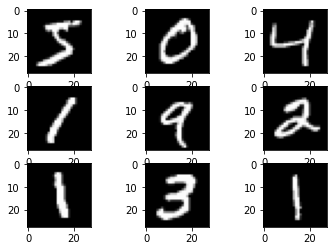


Start of epoch 0
Training acc over epoch: 0.6938
Validation acc: 0.8026

Start of epoch 1
Training acc over epoch: 0.8414
Validation acc: 0.8655

Start of epoch 2
Training acc over epoch: 0.8784
Validation acc: 0.8834

Start of epoch 3
Training acc over epoch: 0.8952
Validation acc: 0.8965

Start of epoch 4
Training acc over epoch: 0.9074
Validation acc: 0.9043

Start of epoch 5
Training acc over epoch: 0.9144
Validation acc: 0.9062

Start of epoch 6
Training acc over epoch: 0.9204
Validation acc: 0.9090


_runtime,75
_timestamp,1622350716
_step,7
epochs,6
loss,0.293
acc,0.92043
val_loss,0.35509
val_acc,0.909


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
acc,▁▆▇▇███
val_loss,█▄▃▂▂▁▁
val_acc,▁▅▆▇███


wandb: Agent Starting Run: csiqsucw with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


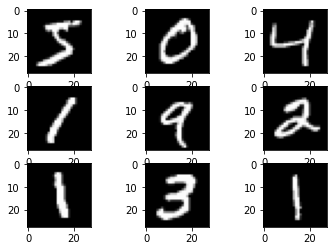


Start of epoch 0
Training acc over epoch: 0.8096
Validation acc: 0.8723

Start of epoch 1
Training acc over epoch: 0.8891
Validation acc: 0.8842

Start of epoch 2
Training acc over epoch: 0.9097
Validation acc: 0.9010

Start of epoch 3
Training acc over epoch: 0.9208
Validation acc: 0.9238

Start of epoch 4
Training acc over epoch: 0.9289
Validation acc: 0.9274

Start of epoch 5
Training acc over epoch: 0.9346
Validation acc: 0.9317

Start of epoch 6
Training acc over epoch: 0.9384
Validation acc: 0.9311


_runtime,77
_timestamp,1622350802
_step,7
epochs,6
loss,0.20772
acc,0.93835
val_loss,0.25367
val_acc,0.9311


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▄▂▁▁▁
val_acc,▁▂▄▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 99fz7v8e with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


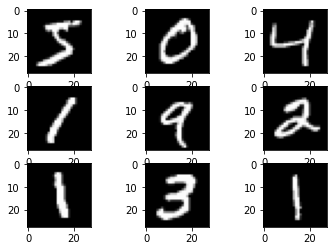


Start of epoch 0
Training acc over epoch: 0.8186
Validation acc: 0.8763

Start of epoch 1
Training acc over epoch: 0.8868
Validation acc: 0.8945

Start of epoch 2
Training acc over epoch: 0.9090
Validation acc: 0.9078

Start of epoch 3
Training acc over epoch: 0.9217
Validation acc: 0.9152

Start of epoch 4
Training acc over epoch: 0.9297
Validation acc: 0.9184

Start of epoch 5
Training acc over epoch: 0.9364
Validation acc: 0.9236

Start of epoch 6
Training acc over epoch: 0.9406
Validation acc: 0.9272


_runtime,74
_timestamp,1622350901
_step,7
epochs,6
loss,0.20782
acc,0.94065
val_loss,0.29054
val_acc,0.9272


_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█
epochs,▁▂▃▅▆▇█
loss,█▂▂▁▁▁▁
acc,▁▅▆▇▇██
val_loss,█▅▃▂▂▁▁
val_acc,▁▄▅▆▇██


wandb: Agent Starting Run: c6grv6mk with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005


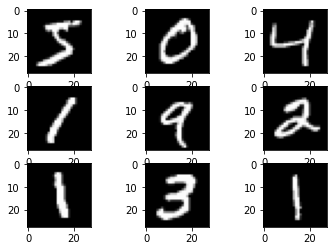


Start of epoch 0
Training acc over epoch: 0.7483
Validation acc: 0.8209

Start of epoch 1
Training acc over epoch: 0.8445
Validation acc: 0.8548

Start of epoch 2
Training acc over epoch: 0.8742
Validation acc: 0.8735

Start of epoch 3
Training acc over epoch: 0.8899
Validation acc: 0.8891

Start of epoch 4
Training acc over epoch: 0.9015
Validation acc: 0.8958

Start of epoch 5
Training acc over epoch: 0.9094
Validation acc: 0.9020

Start of epoch 6
Training acc over epoch: 0.9173
Validation acc: 0.9076


wandb: Processing terminal ouput (stdout)...


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="tf-dhiman")
wandb.agent(sweep_id, function=sweep_train)